In [6]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
import os
import glob
import xarray as xr
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
import joblib
from joblib import Parallel, delayed
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from scipy.stats import qmc
from scipy.interpolate import griddata
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
from tabulate import tabulate
from scipy.optimize import minimize
from matplotlib.animation import FuncAnimation
import threading
import re
import shutil

# CONFIGURATION

In [7]:
# !!!! DO NOT CHANGE !!!!

# absolute levante pathes
icon_dir = '/work/bg1155/COPAT2/ICON-CLM/experiments_linear/yc/mm_yc/results'
observations_dir = '/work/bg1155/COPAT2/ICON-CLM/experiments_linear/ref_data/eobs/mm'
icon_preprocessed = '/work/bg1155/COPAT2/ICON-CLM/experiments_linear/lin_regr'
observations_preprocessed = '/work/bg1155/COPAT2/ICON-CLM/experiments_linear/obs'
config_table = '/home/g/g260232/linear_metamodel_optimizer/Notebooks/ModelParams.xlsx'
regression_output = '/work/bg1155/COPAT2/ICON-CLM/experiments_linear/regr_output'

# variables
list_of_vars = ['tas','rsds','tasmin','tasmax','psl','pr_amount','hfls']
list_of_icon_varnames = ['T_2M','ASOD_S','TMIN_2M','TMAX_2M','PMSL','TOT_PREC','ALHFL_S']
list_of_observations_varnames = ['tg','qq','tn','tx','pp','rr','late']

# the slope parameter of sigmpid
a_slope = 20.0

# !!!! DO NOT CHANGE !!!!

# PREPROCESSING

In [8]:
def parse_simulation_data(filename):
    # Load the Excel file with the correct sheet and headers, treating all cells as strings
    df = pd.read_excel(filename, sheet_name='Sheet1', dtype=str)

    # Print the column names to debug
    print("Column names:", df.columns.tolist())

    # Extract the list of parameters
    parameters = df.columns[1:].tolist()

    # Extract the list of simulation ids
    simulation_ids = df['ID'].tolist()

    # Define the default configuration
    default_config = df[df['ID'] == 'DEF'].iloc[0, 1:].to_dict()

    # Extract minimum, maximum, and reference values
    param_min_values = df[df['ID'] == 'MIN'].iloc[0, 1:].tolist()
    param_max_values = df[df['ID'] == 'MAX'].iloc[0, 1:].tolist()
    param_ref_values = df[df['ID'] == 'REF'].iloc[0, 1:].tolist()
    param_types = df[df['ID'] == 'TYPE'].iloc[0, 1:].tolist()

    # Extract NUMER and DENOM lines
    param_numer_values = df[df['ID'] == 'NUMER'].iloc[0, 1:].tolist()
    param_denom_values = df[df['ID'] == 'DENOM'].iloc[0, 1:].tolist()

    # Remove the rows for MIN, MAX, REF, NUMER, and DENOM from the DataFrame
    df = df[~df['ID'].isin(['DESCR','MIN', 'MAX', 'REF','TYPE','NUMER', 'DENOM'])]

    # Fill missing values with default configuration only if they are truly empty
    for index, row in df.iterrows():
        if index != 0:  # Skip the default configuration row
            for col in parameters:
                # Check if the cell is truly empty
                if pd.isna(row[col]) or row[col] == '':
                    df.at[index, col] = default_config[col]
                elif isinstance(row[col], str) and row[col].lower() == 'nan':  # Handle 'nan' strings explicitly
                    df.at[index, col] = np.nan

    # Ensure all cells are treated as strings and clean data
    for col in parameters:
        df[col] = df[col].apply(lambda x: str(x).strip() if isinstance(x, str) else str(x))

    # Extracting the dictionary: simulation id -> list of parameter values
    sim_id_to_params = df.set_index('ID').T.to_dict('list')

    # Print the dataframe with tabulate, replacing np.nan with 'nan' for display purposes
    df_display = df.replace({np.nan: 'nan'})
    print(tabulate(df_display, headers='keys', tablefmt='pretty'))

    # Return the results
    return parameters, simulation_ids[8:], sim_id_to_params, param_min_values, param_max_values, param_ref_values, param_types, param_numer_values, param_denom_values

In [9]:
out1,out2,out3,out4,out5,out6,out7,out8,out9=parse_simulation_data(filename=config_table)

list_of_params = out1
list_of_sims = out2
sim_to_params = out3
list_params_min = out4
list_params_max = out5
list_params_ref= out6
list_params_type = out7
list_of_params_numer = out8
list_of_params_denom = out9

print('List of simulations: ', list_of_sims)
print('List of parameters: ', list_of_params)
print('List of param min values: ', list_params_min)
print('List of param max values: ', list_params_max)
print('List of param ref values: ', list_params_ref)
print('List of param types: ', list_params_type)
print('List of param numerators: ', list_of_params_numer)
print('List of param denominators: ', list_of_params_denom)

Column names: ['ID', 'mv', 'ao', 'aot2', 'aot4', 'ac', 'ac2', 'taw1', 'taw2', 'rlh', 'rs', 'rl', 'rsmf', 'tbl', 'tbla', 'crb', 'tkhmin', 'sdb', 'acrf', 'oro']
+----+---------+----+-----+------+------+------+-------+------+-------+------+-----+-----+------+------+------+-----+--------+-----+------+-----+
|    |   ID    | mv | ao  | aot2 | aot4 |  ac  |  ac2  | taw1 | taw2  | rlh  | rs  | rl  | rsmf | tbl  | tbla | crb | tkhmin | sdb | acrf | oro |
+----+---------+----+-----+------+------+------+-------+------+-------+------+-----+-----+------+------+------+-----+--------+-----+------+-----+
| 5  |   DEF   | 1  |  1  |  0   |  0   |  0   |   0   |  0   |   0   |  10  | 0.8 |  1  |  1   | 0.05 | 3.25 | 110 |  0.6   |  0  |  0   |  0  |
| 8  | C2I200  | 1  |  1  |  0   |  0   |  0   |   0   | nan  |  nan  |  10  | 0.8 |  1  |  1   | 0.05 | 3.25 | 110 |  0.6   |  0  |  0   |  0  |
| 9  | C2I200c | 1  |  1  |  0   |  0   |  0   |   0   | nan  |  nan  |  10  | 0.8 |  1  |  1   | 0.05 | 3.25 |

In [10]:
# EXTRACT NETCDF FILES TO NUMPY ARRAYS
def extract_data(data_dir,
                 output_dir,
                 list_of_vars,
                 list_of_varnames):

    output = {}
    
    # check if data dir exist
    if (not os.path.isdir(data_dir)):
        raise Exception(f'The data directory: \'{data_dir}\' does not exist! Abort!')
    
    # check if dir for each variable exist
    for var in list_of_vars:
        vardir=os.path.join(data_dir, var)
        if (not os.path.isdir(vardir)):
            raise Exception(f'The data directory for variable: \'{vardir}\' does not exist! Abort!')

    # check if output dir exist
    if (not os.path.isdir(output_dir)):
        os.makedirs(output_dir)

    # create the separate directory for each variable if it is not exist
    for var in list_of_vars:
        vardir=os.path.join(output_dir, var)
        if not os.path.isdir(vardir):
            # Create the directory
            os.makedirs(vardir)

    # read all files using xarray library and save the result as np.array
    for i, var in enumerate(list_of_vars):
        vardir=os.path.join(data_dir, var)
        output_vardir=os.path.join(output_dir, var)
        output_file = os.path.join(output_vardir, var+'.npy')

        if not (os.path.isfile(output_file)):

            # get the filename in the directory 
            files = glob.glob(os.path.join(vardir, '*'))
            file = os.path.abspath(files[0])

            # extract the file and save zipped version
            ds_var = xr.open_dataset(file)
            array = ds_var[list_of_varnames[i]]
            np.save(output_file, array)
            
        output[var] = output_file

    return output

In [11]:
# EXTRACT ICON OUTPUT AND OBSERVATION DATA TO NUMPY ARRAYS

def prepare_model_outputs():
    model_output_files = {}
    
    for sim in list_of_sims+['C2I207']:
        all_data_dir=icon_dir
        all_output_dir=icon_preprocessed
        model_output_files[sim] = extract_data(data_dir=os.path.join(all_data_dir, sim),
                                               output_dir=os.path.join(all_output_dir, sim),
                                               list_of_vars=list_of_vars,
                                               list_of_varnames=list_of_icon_varnames)
        print(sim+' DONE!')
        
    return model_output_files

def prepare_observations_files():
    observations_files = {}
    observations_files = extract_data(data_dir=observations_dir,
                                      output_dir=observations_preprocessed,
                                      list_of_vars=list_of_vars,
                                      list_of_varnames=list_of_observations_varnames)
    print('OBSEVATIONS DONE!')
    return observations_files

In [12]:
# PREPROCESSING
model_output_files = prepare_model_outputs()
observations_files = prepare_observations_files()

C2I200 DONE!
C2I200c DONE!
C2I201 DONE!
C2I202 DONE!
C2I203 DONE!
C2I204 DONE!
C2I205 DONE!
C2I206 DONE!
C2I208c DONE!
C2I214c DONE!
C2I217c DONE!
C2I220c DONE!
C2I222c DONE!
C2I230 DONE!
C2I235 DONE!
C2I232 DONE!
C2I240 DONE!
C2I241 DONE!
C2I245 DONE!
C2I268c DONE!
C2I271c DONE!
C2I277c DONE!
C2I279c DONE!
C2I280c DONE!
C2I284c DONE!
C2I285c DONE!
C2I286c DONE!
C2I287c DONE!
C2I288c DONE!
C2I289c DONE!
C2I290c DONE!
C2I207 DONE!
OBSEVATIONS DONE!


# TRAINING + SENSITIVITY ASSESSMENTS

In [13]:
# store disturbance rmse
disturbance_rmse = {}
for variable in list_of_vars:
    ref_sim = np.load(model_output_files['C2I200'][variable])
    dist_sim = np.load(model_output_files['C2I207'][variable])
    NT,NX,NY = ref_sim.shape
    squared_differences = (ref_sim - dist_sim) ** 2
    sum_squared_differences = np.sum(squared_differences, axis=(1, 2))
    normalized_sums = sum_squared_differences / (NX*NY)
    disturbance_rmse[variable] = np.sqrt(normalized_sums)

In [14]:
# function to parse linear combinations
def extract_linear_combination(expression):
    # Regular expression to match the terms including optional coefficients and the simulation IDs
    pattern = r'([+-]?[\d\.]*)\*?(C2I\d+c?)'
    
    matches = re.findall(pattern, expression)
    
    list_of_sims = []
    list_of_coeffs = []
    
    for coeff, sim_id in matches:
        if coeff in ['', '+', '-']:  # Handle implied coefficients
            coeff = '1' if coeff in ['', '+'] else '-1'
        list_of_sims.append(sim_id)
        list_of_coeffs.append(float(coeff))
    
    return list_of_sims, list_of_coeffs

# SOME TEST CASES
o1, o2 = extract_linear_combination('C2I205-C2I200')
print(o1)
print(o2)
print()

o1, o2 = extract_linear_combination('0.5*C2I205c-C2I200')
print(o1)
print(o2)
print()

o1, o2 = extract_linear_combination('C2I205c-0.7*C2I200+0.8*C2I266c')
print(o1)
print(o2)
print()

['C2I205', 'C2I200']
[1.0, -1.0]

['C2I205c', 'C2I200']
[0.5, -1.0]

['C2I205c', 'C2I200', 'C2I266c']
[1.0, -0.7, 0.8]



In [15]:
def display_colored_table(data):
    
    # Convert the nested dictionary to a DataFrame
    df = pd.DataFrame(data)

    # Calculate the sum for each row and add it as a new column
    df['Sum'] = df.sum(axis=1)

    # Define a function to apply the color gradient
    def color_gradient(val):
        
        if pd.isna(val):
            return ''
        norm = (val - df.drop(columns='Sum').values.min()) / (df.drop(columns='Sum').values.max() - df.drop(columns='Sum').values.min())
        color = plt.cm.coolwarm(norm)
        return f'background-color: rgba({int(color[0]*255)}, {int(color[1]*255)}, {int(color[2]*255)}, {color[3]})'

    # Apply the color gradient to the DataFrame except for the 'Sum' column
    styled_df = df.style.applymap(color_gradient, subset=pd.IndexSlice[:, df.columns.difference(['Sum'])])

    # Display the styled DataFrame
    display(styled_df)

In [16]:
def train_K(basedir='regression_output'):
    var_to_param_K = {}
    var_to_param_sens = {}

    print(f'The regression K output would be written to \'{basedir}\'')

    Nt, Nx, Ny = np.load(model_output_files[list_of_sims[0]][list_of_vars[0]]).shape

    for var in list_of_vars:
        var_dir = os.path.join(basedir, 'Ktensor', var)

        if os.path.exists(var_dir):
            # Directory exists, clean it
            shutil.rmtree(var_dir)
            os.makedirs(var_dir)
        else:
            os.makedirs(var_dir)

        current_var_K = {}
        current_var_sens = {}

        for i, param in enumerate(list_of_params[1:], start=1):
            param_file = os.path.join(var_dir, param + '.npy')
            current_var_K[param] = param_file

            print(f'Train K-tensor for variable \'{var}\', parameter \'{param}\'')

            numerator = np.zeros((Nt, Nx, Ny))
            current_sims, current_coeffs = extract_linear_combination(list_of_params_numer[i])
            for sim, coeff in zip(current_sims, current_coeffs):
                numerator += np.load(model_output_files[sim][var]) * coeff

            denominator = 0
            if (list_of_params_denom[i] == 'NAN'):
                denominator=1.0
            else:
                current_sims, current_coeffs = extract_linear_combination(list_of_params_denom[i])
                for sim, coeff in zip(current_sims, current_coeffs):
                    denominator += float(sim_to_params[sim][i]) * coeff

            current_K = numerator / denominator
            np.save(param_file, current_K)

            # Compute the signal rmse
            min_param = float(list_params_min[i])
            max_param = float(list_params_max[i])
            ref_param = float(list_params_ref[i])

            min_predict = current_K * (ref_param - min_param)
            max_predict = current_K * (ref_param - max_param)

            min_sensitivity_rmse = np.mean((np.sqrt(np.sum(min_predict ** 2, axis=(1, 2)) / (Nx * Ny)) / disturbance_rmse[var]))
            max_sensitivity_rmse = np.mean((np.sqrt(np.sum(max_predict ** 2, axis=(1, 2)) / (Nx * Ny)) / disturbance_rmse[var]))

            current_var_sens[param] = max(min_sensitivity_rmse, max_sensitivity_rmse)

        var_to_param_sens[var] = current_var_sens
        var_to_param_K[var] = current_var_K

    display_colored_table(var_to_param_sens)

    return var_to_param_K

In [17]:
var_to_param_K = train_K(basedir=regression_output)

The regression K output would be written to '/work/bg1155/COPAT2/ICON-CLM/experiments_linear/regr_output'
Train K-tensor for variable 'tas', parameter 'ao'
Train K-tensor for variable 'tas', parameter 'aot2'
Train K-tensor for variable 'tas', parameter 'aot4'
Train K-tensor for variable 'tas', parameter 'ac'
Train K-tensor for variable 'tas', parameter 'ac2'
Train K-tensor for variable 'tas', parameter 'taw1'
Train K-tensor for variable 'tas', parameter 'taw2'
Train K-tensor for variable 'tas', parameter 'rlh'
Train K-tensor for variable 'tas', parameter 'rs'
Train K-tensor for variable 'tas', parameter 'rl'
Train K-tensor for variable 'tas', parameter 'rsmf'
Train K-tensor for variable 'tas', parameter 'tbl'
Train K-tensor for variable 'tas', parameter 'tbla'
Train K-tensor for variable 'tas', parameter 'crb'
Train K-tensor for variable 'tas', parameter 'tkhmin'
Train K-tensor for variable 'tas', parameter 'sdb'
Train K-tensor for variable 'tas', parameter 'acrf'
Train K-tensor for va

/tmp/ipykernel_1004016/2894518762.py:19: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = df.style.applymap(color_gradient, subset=pd.IndexSlice[:, df.columns.difference(['Sum'])])


In [18]:
def sigma_a(s):
    return 1.0/(1+np.exp(-a_slope*(s-0.5)))

def grad_sigma_a(s):
    return a_slope*sigma_a(s)*(1.0-sigma_a(s))

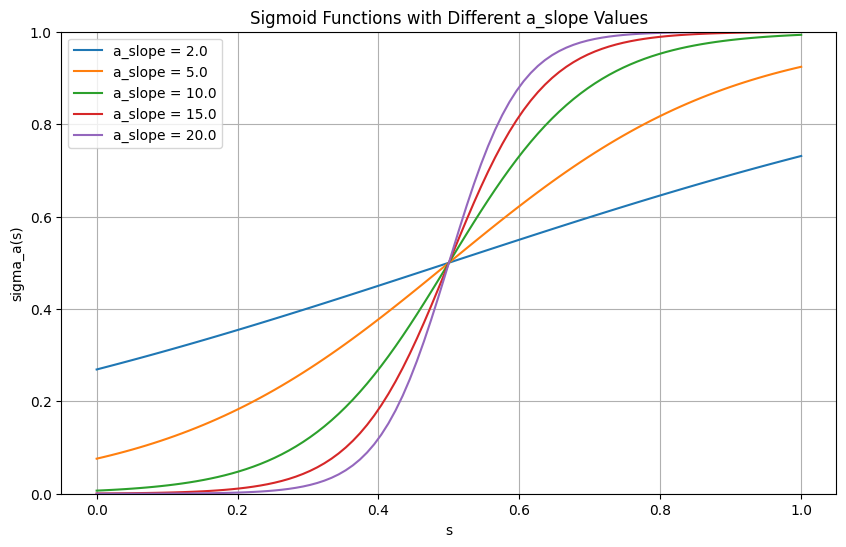

In [19]:
# Define the range of s values
s_values = np.linspace(0, 1, 100)

# Define different a_slope values to compare
a_slope_values = [2.0, 5.0, 10.0, 15.0, 20.0]

# Plot the sigmoid functions for different a_slope values
plt.figure(figsize=(10, 6))
for a_slope in a_slope_values:
    plt.plot(s_values, sigma_a(s_values), label=f'a_slope = {a_slope}')
    
plt.xlabel('s')
plt.ylabel('sigma_a(s)')
plt.title('Sigmoid Functions with Different a_slope Values')
plt.legend()
plt.grid(True)
plt.ylim([0, 1])  # Ensure y-axis is within [0, 1]
plt.show()

In [20]:
def train_A(set_of_parameters_dict, basedir='regression_output'):
    Nt, Nx, Ny = np.load(model_output_files[list_of_sims[0]][list_of_vars[0]]).shape
    var_to_setup_A = {}
    print(f'The regression A output would be written to \'{basedir}\'')

    for var in list_of_vars:
        
        var_dir = os.path.join(basedir, 'Atensor', var)

        if os.path.exists(var_dir):
            # Directory exists, clean it
            shutil.rmtree(var_dir)
            os.makedirs(var_dir)
        else:
            os.makedirs(var_dir)

        current_var_to_setup_A = {}
        
        for setup, current_setup_info in set_of_parameters_dict.items():

            print(f'Computing A tensor for variable \'{var}\' and setup \'{setup}\'!')
            
            current_reference = current_setup_info['reference']
            current_params = current_setup_info['parameters']
            list_of_indexes = [list_of_params.index(item) for item in current_params]
            curren_reference_param_values = [float(sim_to_params[current_reference][i]) for i in list_of_indexes]

            current_setup_file = os.path.join(var_dir, setup + '.npy')

            current_var_A = np.load(model_output_files[current_reference][var])

            for i, param in enumerate(current_params):
                if (list_params_type[list_of_indexes[i]] == 'continous'):
                    current_var_A -= np.load(var_to_param_K[var][param]) * curren_reference_param_values[i]
                elif (list_params_type[list_of_indexes[i]] == 'binary'):
                    current_var_A -= np.load(var_to_param_K[var][param]) * sigma_a(curren_reference_param_values[i])
                else:
                    raise Exception('Only continous and binary parameters could be used!')
                    
            np.save(current_setup_file, current_var_A)
            current_var_to_setup_A[setup] = current_setup_file

        var_to_setup_A[var] = current_var_to_setup_A

    return var_to_setup_A

## HERE TO SETUP NEW CONFIGURATION

In [21]:
setup_dict = {
    'p251': {
        'reference': 'C2I271c',
        'parameters': ['rs','rl','rlh','rsmf','tbl','tbla','ao','aot4','taw1','ac2'],
        'weights': [0.15,0.15,0.15,0.15,0.15,0.2,0.05]},
    'p252': {
        'reference': 'C2I271c',
        'parameters': ['rs','rl','rlh','rsmf','tbl','tbla','ao','aot4','taw1','ac2'],
        'weights': [0.15,0.1,0.15,0.15,0.15,0.2,0.1]},
    'p351': {
        'reference': 'C2I288c',
        'parameters': ['rs','rl','rlh','rsmf','tbl','tbla','ao','aot4','taw1','ac2'],
        'weights': [0.15,0.1,0.15,0.15,0.15,0.2,0.1]},
    'p352': {
        'reference': 'C2I288c',
        'parameters': ['rs','rl','rlh','rsmf','tbl','tbla','ao','aot4','taw1','ac2'],
        'weights': [0.15,0.15,0.15,0.15,0.15,0.2,0.05]},
    'p441': {
        'reference': 'C2I290c',
        'parameters': ['rs','rl','rlh','rsmf','tbl','tbla','ao','ac'],
        'weights': [0.15,0.1,0.15,0.15,0.15,0.2,0.1]},
    'p442': {
        'reference': 'C2I290c',
        'parameters': ['rs','rl','rlh','rsmf','tbl','tbla','ao','ac'],
        'weights': [0.15,0.15,0.15,0.15,0.15,0.2,0.05]},
    'p451': {
        'reference': 'C2I290c',
        'parameters': ['rs','rl','rlh','rsmf','tbl','tbla','ao','aot4','taw1','taw2'],
        'weights': [0.15,0.15,0.15,0.15,0.15,0.2,0.05]},
    'p452': {
        'reference': 'C2I290c',
        'parameters': ['rs','rl','rlh','rsmf','tbl','tbla','ao','aot4','taw1','taw2'],
        'weights': [0.15,0.1,0.15,0.15,0.15,0.2,0.1]},
    'p541': {
        'reference': 'C2I200',
        'parameters': ['rs','rl','rlh','rsmf','tbl','tbla','ao','ac'],
        'weights': [0.15,0.1,0.15,0.15,0.15,0.2,0.1]},
    'p641': {
        'reference': 'C2I200c',
        'parameters': ['rs','rl','rlh','rsmf','tbl','tbla','ao','ac'],
        'weights': [0.15,0.1,0.15,0.15,0.15,0.2,0.1]},
    'p_test_binary': {
        'reference': 'C2I288c',
        'parameters': ['rs','rl','rlh','rsmf','tbl','tbla','ao','aot4','ac','tkhmin','sdb','acrf','oro'],
        'weights': [0.15,0.15,0.15,0.15,0.15,0.2,0.05]}
}

var_to_setup_A = train_A(set_of_parameters_dict=setup_dict,
                         basedir=regression_output)

The regression A output would be written to '/work/bg1155/COPAT2/ICON-CLM/experiments_linear/regr_output'
Computing A tensor for variable 'tas' and setup 'p251'!
Computing A tensor for variable 'tas' and setup 'p252'!
Computing A tensor for variable 'tas' and setup 'p351'!
Computing A tensor for variable 'tas' and setup 'p352'!
Computing A tensor for variable 'tas' and setup 'p441'!
Computing A tensor for variable 'tas' and setup 'p442'!
Computing A tensor for variable 'tas' and setup 'p451'!
Computing A tensor for variable 'tas' and setup 'p452'!
Computing A tensor for variable 'tas' and setup 'p541'!
Computing A tensor for variable 'tas' and setup 'p641'!
Computing A tensor for variable 'tas' and setup 'p_test_binary'!
Computing A tensor for variable 'rsds' and setup 'p251'!
Computing A tensor for variable 'rsds' and setup 'p252'!
Computing A tensor for variable 'rsds' and setup 'p351'!
Computing A tensor for variable 'rsds' and setup 'p352'!
Computing A tensor for variable 'rsds' an

In [22]:
def predict_linear(setup, parameter_values, setup_dict=setup_dict):
    
    #print(setup_dict[setup]['parameters'])
    #print(parameter_values)
    if len(parameter_values) != (len(setup_dict[setup]['parameters'])):
        raise Exception('len(parameter_values) != number of parameters in setup')

    var_to_prediction = {}
    for var in list_of_vars:
        current_var_res = np.load(var_to_setup_A[var][setup])
        current_params = setup_dict[setup]['parameters']
        list_of_indexes = [list_of_params.index(item) for item in current_params]
        for i, param in enumerate(current_params):
            if (list_params_type[list_of_indexes[i]] == 'continous'):
                current_var_res += parameter_values[i] * np.load(var_to_param_K[var][param])
            elif (list_params_type[list_of_indexes[i]] == 'binary'):
                current_var_res += sigma_a(parameter_values[i]) * np.load(var_to_param_K[var][param])
        var_to_prediction[var] = current_var_res
    return var_to_prediction

# VALIDATION (TO DO)

In [125]:
def compute_r2(x, y):
    # Ensure x and y are numpy arrays
    x = np.array(x)
    y = np.array(y)
    
    # Calculate the mean of y
    mean_y = np.mean(y)
    
    # Total sum of squares (SST)
    sst = np.sum((y - mean_y) ** 2)
    
    # Residual sum of squares (SSR)
    ssr = np.sum((y - x) ** 2)
    
    # R^2 coefficient of determination
    r2 = 1 - (ssr / sst)
    
    return r2
    
def plot_model_assesment_score(model_predictor,
                               param_dict=validation_params,
                               model_output_dict=model_output_files,
                               list_of_vars=['tas', 'rsds', 'tasmin', 'tasmax', 'psl', 'pr_amount','hfls']):

    NT,NX,NY = np.load(model_output_dict[list(param_dict.keys())[0]][list_of_vars[0]]).shape
    total_pairs_for_var=NT*NX*NY
    var_to_value_pairs={var: [] for var in list_of_vars}
    
    for sim, params in param_dict.items():
        regression_output_dict=model_predictor(params)
        dynamical_model_output_dict = {var: np.load(model_output_dict[sim][var]) for var in list_of_vars}

        for var in list_of_vars:
            with tqdm(total=total_pairs_for_var, desc=f'Assembling pairs for var \'{var}\'') as pbar:
                for reg_value, dyn_value in zip(regression_output_dict[var].flatten(), dynamical_model_output_dict[var].flatten()):
                    var_to_value_pairs[var].append([reg_value, dyn_value])
                    pbar.update(1)


    for var in list_of_vars:
        x=np.array(var_to_value_pairs[var])[:, 0]
        y=np.array(var_to_value_pairs[var])[:, 1]
        r2=compute_r2(x,y)
        print(f'R^2 = {r2:.6f}')
        min_val = min(np.min(x), np.min(y))
        max_val = max(np.max(x), np.max(y))
        plt.scatter(x[::100], y[::100], s=1, alpha=0.1, color='gray')
        plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='-', linewidth=2, label=f'R^2 = {r2:.6f}')
        plt.title(f'Regression prediction vs CLM prediction for each gridpoint for \'{var}\'')
        plt.xlabel('Regression prediction')
        plt.ylabel('CLM prediction')
        plt.grid(True,linestyle=':')
        plt.legend()
        plt.show()

NameError: name 'validation_params' is not defined

In [126]:
plot_model_assesment_score(model_predictor=lambda p: predict_linear(p, list_of_vars=['tas', 'rsds', 'tasmin', 'tasmax', 'psl', 'pr_amount','hfls']),
                           list_of_vars=['tas','rsds', 'tasmin', 'tasmax', 'psl', 'pr_amount','hfls'])

NameError: name 'plot_model_assesment_score' is not defined

# SCORE + GRADIENT

In [23]:
def compute_score(regression_prediction,
                  setup,
                  disturbance_rmse=disturbance_rmse):
    
    var_rmses = []
    for variable in list_of_vars:
        
        observations_array=np.load(observations_files[variable])
        predictions_array=regression_prediction[variable]
        nan_mask_pred = np.isnan(predictions_array)
        nan_mask_obs = np.isnan(observations_array)

        nan_mask = nan_mask_pred | nan_mask_obs
    
        if np.all(nan_mask):
            raise Exception(f'The model and observations datasets don\'t have the common gridpoints! Can not compute the spatial RMSE! Abort!')
            
        # Calculate the squared differences, ignoring NaN positions
        squared_differences = (predictions_array - observations_array) ** 2
    
        # Apply mask: set differences to 0 where ref is NaN
        squared_differences[nan_mask] = 0
    
        # Sum over spatial dimensions
        sum_squared_differences = np.sum(squared_differences, axis=(1, 2))
    
        # Count non-NaN spatial points per sample
        num_spatial_points = np.sum(~nan_mask, axis=(1, 2))  # ~nan_mask gives the inverse of nan_mask
    
        # Normalize by the number of non-NaN spatial points
        normalized_sums = sum_squared_differences / num_spatial_points
    
        # Compute the square root of normalized sums to get the L2 norm
        rmses = np.sqrt(normalized_sums)

        rmses_normalized_by_dist = rmses / disturbance_rmse[variable]

        # compute the average of rmses over all periods
        avg_rmse = np.mean(rmses_normalized_by_dist)
        var_rmses.append(avg_rmse)

    result = []
    for i in range(len(list_of_vars)):
        result.append(setup_dict[setup]['weights'][i]*var_rmses[i])
    result = np.array(result)
    
    return result

def compute_score_gradient(parameter_values, setup, disturbance_rmse=disturbance_rmse):
    regression_prediction = predict_linear(setup, parameter_values)
    Np = len(setup_dict[setup]['parameters'])
    list_of_indexes = [list_of_params.index(item) for item in setup_dict[setup]['parameters']]
    
    score_gradient = np.zeros(Np)
    weights = setup_dict[setup]['weights']
    
    # Identify continuous and binary indices
    continuous_indices = np.array([i for i in range(Np) if list_params_type[list_of_indexes[i]] == 'continous'])
    binary_indices = np.array([i for i in range(Np) if list_params_type[list_of_indexes[i]] == 'binary'])
    
    # Precompute gradients for all variables
    shape = regression_prediction[list_of_vars[0]].shape
    if continuous_indices.size > 0:
        continuous_gradients = np.zeros((len(list_of_vars), len(continuous_indices), *shape), dtype=np.float32)
    if binary_indices.size > 0:
        binary_gradients = np.zeros((len(list_of_vars), len(binary_indices), *shape), dtype=np.float32)
    
    for var_num, variable in enumerate(list_of_vars):
        for idx, i in enumerate(continuous_indices):
            param = setup_dict[setup]['parameters'][i]
            continuous_gradients[var_num, idx] = np.load(var_to_param_K[variable][param])
        
        for idx, i in enumerate(binary_indices):
            param = setup_dict[setup]['parameters'][i]
            binary_gradients[var_num, idx] = np.load(var_to_param_K[variable][param]) * grad_sigma_a(parameter_values[i])
    
    for var_num, variable in enumerate(list_of_vars):
        observations_array = np.load(observations_files[variable])
        predictions_array = regression_prediction[variable]

        nan_mask = np.isnan(predictions_array) | np.isnan(observations_array)

        # Compute RMSE for current variable
        squared_differences = np.where(nan_mask, 0, (predictions_array - observations_array) ** 2)
        sum_squared_differences = np.sum(squared_differences, axis=(1, 2))
        num_spatial_points = np.sum(~nan_mask, axis=(1, 2))
        rmse = np.sqrt(sum_squared_differences / num_spatial_points)

        # Compute RMSE gradient
        differences_array = np.where(nan_mask, 0, predictions_array - observations_array)
        
        # Create an array to hold the combined gradients
        gradient_array = np.zeros(differences_array.shape + (Np,), dtype=np.float32)
        
        # Assign the precomputed gradients in a vectorized way
        if continuous_indices.size > 0:
            continuous_gradient_subset = continuous_gradients[var_num].transpose(1, 2, 3, 0)
            gradient_array[..., continuous_indices] = continuous_gradient_subset
        if binary_indices.size > 0:
            binary_gradient_subset = binary_gradients[var_num].transpose(1, 2, 3, 0)
            gradient_array[..., binary_indices] = binary_gradient_subset
        
        rmse_gradient = np.einsum('tij,tijp->ptij', differences_array, gradient_array)

        spatial_avg = np.sum(rmse_gradient, axis=(2, 3))

        # Reshape arrays to ensure proper broadcasting
        num_spatial_points_reshaped = num_spatial_points[np.newaxis, :]
        rmse_reshaped = rmse[np.newaxis, :]
        disturbance_rmse_reshaped = disturbance_rmse[variable][np.newaxis, :]

        err_monthly_gradient = spatial_avg / num_spatial_points_reshaped / rmse_reshaped / disturbance_rmse_reshaped

        err_gradient = err_monthly_gradient.mean(axis=1) * weights[var_num]

        score_gradient += err_gradient

    return score_gradient

In [24]:
%%time
compute_score(regression_prediction=predict_linear('p251', [1.0,1.0,10.0,1.0,0.06,3.0,0.9,0.3,0.1,-0.1]),setup='p251')

CPU times: user 177 ms, sys: 290 ms, total: 468 ms
Wall time: 1.1 s


array([2.12066945, 1.03409764, 1.83565208, 2.05766287, 1.54341937,
       0.82346282, 0.90826227])

In [25]:
%%time
compute_score_gradient(parameter_values=[1.0,1.0,10.0,1.0,0.06,3.0,0.9,0.3,0.1,-0.1],setup='p251')

CPU times: user 1.13 s, sys: 830 ms, total: 1.96 s
Wall time: 2.03 s


array([ 3.12260743e-01, -7.93225027e-02,  7.06450146e-02, -2.74393487e-01,
       -5.94041588e+00, -2.02337070e-01, -9.40644865e-02,  1.54302979e-03,
        1.50148313e+00,  9.30888287e-01])

# OPTIMIZATION

In [26]:
def plot_pair_of_bars(initial_scores, optimal_scores, labels, labels2, title, ylabel):
    
    n = len(initial_scores)
    ind = np.arange(n)  # Positions for the categories
    width = 0.35

    fig, ax = plt.subplots()

    # Plotting the bars for the individual values
    bar1 = ax.bar(ind, initial_scores, width, label='Initial setup')
    bar2 = ax.bar(ind + width, optimal_scores, width, label='Optimal setup')

    # Adding primary x-axis labels
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(labels)

    # Adding secondary x-axis labels
    ax_secondary = ax.twiny()
    ax_secondary.set_xlim(ax.get_xlim())
    ax_secondary.set_xticks(ind + width / 2)
    ax_secondary.set_xticklabels(labels2)
    ax_secondary.xaxis.set_ticks_position('bottom')
    ax_secondary.xaxis.set_label_position('bottom')
    ax_secondary.spines['bottom'].set_position(('outward', 40))

    # Adding legend and grid
    ax.legend()
    ax.grid(True, linestyle='--', which='both', color='gray', alpha=0.7)

    plt.show()

In [27]:
def print_table(names, array1, array2):
    # Creating a DataFrame
    data = {
        'Params': ['Initial params', 'Optimal params'],
        **{names[i]: [array1[i], array2[i]] for i in range(len(names))}
    }

    df = pd.DataFrame(data)
    df.set_index('Params', inplace=True)

    # Remove the name of the index column
    df.index.name = None

    # Apply styling to make row and column names bold
    styled_df = df.style.set_table_styles(
        [{'selector': 'th', 'props': [('font-weight', 'bold')]}]
    )

    # Display the styled DataFrame
    display(styled_df)

In [28]:
def normalize(params, bounds):
    return [(p - low) / (high - low) for p, (low, high) in zip(params, bounds)]

def denormalize(params, bounds):
    return [low + p * (high - low) for p, (low, high) in zip(params, bounds)]
    
def optimize_and_plot(setup,
                      initial_params=None,
                      search_range=None,
                      verbose=True):
    
    # Log setup
    list_of_indexes = [list_of_params.index(item) for item in setup_dict[setup]['parameters']]
    curren_setup_min_values = [float(list_params_min[i]) for i in list_of_indexes]
    curren_setup_max_values = [float(list_params_max[i]) for i in list_of_indexes]
    
    if (search_range != None):
        search_range=search_range
    else:  
        search_range = [[curren_setup_min_values[i], curren_setup_max_values[i]] for i in range(len(list_of_indexes))]
   
    if (initial_params != None):
        initial_params = initial_params
    else:
        initial_params = [float(sim_to_params[setup_dict[setup]['reference']][i]) if (list_params_type[i] == 'continous')
                          else 0.5 if (list_params_type[i] == 'binary')
                          else Exception('Only continous and binary variables available')
                          for i in list_of_indexes]
        
    variable_weights = setup_dict[setup]['weights']
    
    print('SETUP: ', setup)
    print('REFERENCE SIMULATION: ', setup_dict[setup]['reference'])
    print('LIST OF PARAMETERS: ', setup_dict[setup]['parameters'])
    print('INITIAL PARAMETERS: ', initial_params)
    print('SEARCH RANGE: ', search_range)
    print('LIST OF VARIABLES: ', list_of_vars)
    print('VARIABLE WEIGHTS:', variable_weights)
    
    initial_scores = compute_score(predict_linear(setup, initial_params), setup)

    # Normalize initial parameters and search range
    normalized_initial_params = normalize(initial_params, search_range)
    normalized_bounds = [(0, 1) for _ in search_range]
    
    # Define lists to store the progress
    iteration_data = []
    function_values = []
    gradient_norms = []

    # Define the objective function wrapper
    def objective_function(param_list):
        denorm_params = denormalize(param_list, search_range)
        prediction = predict_linear(setup, denorm_params)
        return compute_score(prediction, setup).sum()

    # Define the gradient function wrapper
    def gradient_function(param_list):
        denorm_params = denormalize(param_list, search_range)
        grad = compute_score_gradient(denorm_params, setup)
        range_values = [high - low for low, high in search_range]
        normalized_grad = [g * r for g, r in zip(grad, range_values)]
        return normalized_grad

    # Define the callback function
    def callback(xk):
        iteration = len(iteration_data) + 1
        iteration_data.append(iteration)
        function_value = objective_function(xk)
        gradient_value = gradient_function(xk)
        function_values.append(function_value)
        gradient_norms.append(np.linalg.norm(gradient_value))
        print(f"Iteration {iteration}: Objective Function Value = {function_value}, Gradient Norm = {np.linalg.norm(gradient_value)}")

    # Run the optimization
    result = minimize(
        fun=objective_function,
        x0=normalized_initial_params,
        jac=gradient_function,
        bounds=normalized_bounds,
        method='L-BFGS-B',
        callback=callback,
        options={'maxiter': 200, 'disp': True}
    )

    # Denormalize the optimal parameter values
    best_params_descent = denormalize(result.x, search_range)

    final_scores=compute_score(predict_linear(setup, best_params_descent), setup)
    

    if (verbose):
        # Plotting function value vs. iteration number
        plt.figure(figsize=(14, 6))

        plt.subplot(1, 2, 1)
        plt.plot(iteration_data, function_values, 'b-', marker='o')
        plt.xlabel('Iteration')
        plt.ylabel('Objective Function Value')
        plt.title('Objective Function Value vs. Iteration Number')
        plt.grid(True)

        # Plotting gradient norm vs. iteration number
        plt.subplot(1, 2, 2)
        plt.plot(iteration_data, gradient_norms, 'r-', marker='o')
        plt.xlabel('Iteration')
        plt.ylabel('Gradient Norm')
        plt.title('Gradient Norm vs. Iteration Number')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        # plot optimized scores
        plot_pair_of_bars(initial_scores=initial_scores,
                          optimal_scores=final_scores,
                          labels=[list_of_vars[i]+'(L)' for i in range(len(list_of_vars)-1)]+[list_of_vars[-1]+'(W)'],
                          labels2=setup_dict[setup]['weights'],
                          title='Initial vs Optimal scores',
                          ylabel='Score'
                          )

        # plot old/new parameter values
        print_table(names=setup_dict[setup]['parameters'],
                    array1=initial_params,
                    array2=best_params_descent)

    # Display the optimization result and best parameters
    print("Optimization Result:")
    print(result)
    print("Optimal Parameters (best_params_descent):")
    print(best_params_descent)

    return best_params_descent, result

SETUP:  p251
REFERENCE SIMULATION:  C2I271c
LIST OF PARAMETERS:  ['rs', 'rl', 'rlh', 'rsmf', 'tbl', 'tbla', 'ao', 'aot4', 'taw1', 'ac2']
INITIAL PARAMETERS:  [0.8, 1.0, 6.25, 1.0, 0.05, 3.25, 0.9, 0.0, 0.0, 0.0]
SEARCH RANGE:  [[0.5, 1.5], [0.7, 1.3], [5.0, 12.0], [0.7, 1.5], [0.04, 0.1], [2.5, 4.5], [0.8, 1.0], [0.0, 1.5], [0.0, 0.15], [-0.15, 0.0]]
LIST OF VARIABLES:  ['tas', 'rsds', 'tasmin', 'tasmax', 'psl', 'pr_amount', 'hfls']
VARIABLE WEIGHTS: [0.15, 0.15, 0.15, 0.15, 0.15, 0.2, 0.05]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         3 variables are exactly at the bounds

At iterate    0    f=  1.05087D+01    |proj g|=  4.62039D-01

At iterate    1    f=  1.03536D+01    |proj g|=  4.70632D-01
Iteration 1: Objective Function Value = 10.35363969456158, Gradient Norm = 0.9884779804676007

At iterate    2    f=  1.02411D+01    |proj g|=  2.75086D-01
Iteration 2: Objective Function Value = 10.2410879637955

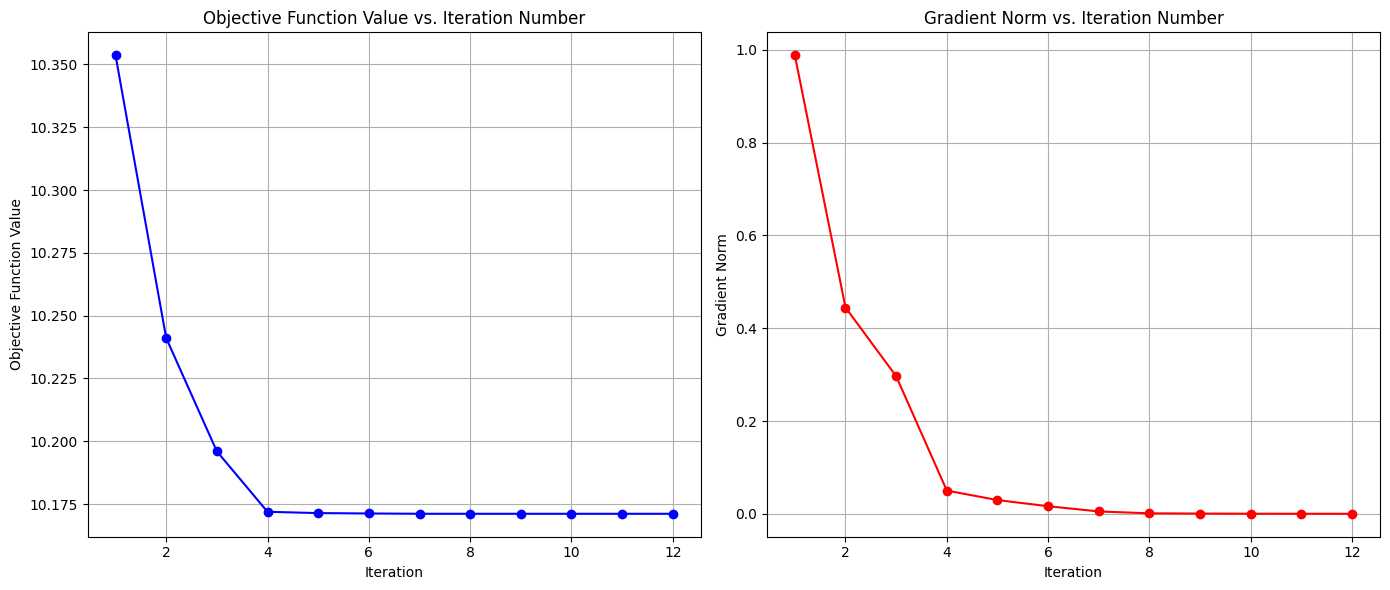

Optimization Result:
      fun: 10.171123326828358
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.08776822e-05, -1.31203045e-05,  1.57900911e-06,  8.06961271e-08,
       -1.69625235e-05, -1.93031985e-05,  1.58280935e-05,  5.87936786e-06,
       -9.80640906e-06,  2.03910356e-06])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 14
      nit: 12
     njev: 14
   status: 0
  success: True
        x: array([0.42676841, 0.54441815, 0.34483797, 0.46386093, 0.31011354,
       0.39228858, 0.59598887, 0.21572735, 0.55477048, 0.3670671 ])
Optimal Parameters (best_params_descent):
[0.9267684117485789, 1.0266508895383901, 7.4138657805560495, 1.0710887423475923, 0.058606812316347665, 3.284577158988699, 0.9191977737543668, 0.32359103063616496, 0.08321557258993205, -0.09493993554491059]
CPU times: user 34.8 s, sys: 25.4 s, total: 1min
Wall time: 1min 4s


In [109]:
%%time
best_params, objective_function = optimize_and_plot(setup='p251')

SETUP:  p_test_binary
REFERENCE SIMULATION:  C2I288c
LIST OF PARAMETERS:  ['rs', 'rl', 'rlh', 'rsmf', 'tbl', 'tbla', 'ao', 'aot4', 'ac', 'tkhmin', 'sdb', 'acrf', 'oro']
INITIAL PARAMETERS:  [0.8, 1.0, 6.25, 1.0, 0.05, 3.25, 0.9, 0.0, 0.0, 0.6, 0.5, 0.5, 0.5]
SEARCH RANGE:  [[0.5, 1.5], [0.7, 1.3], [5.0, 12.0], [0.7, 1.5], [0.04, 0.1], [2.5, 4.5], [0.8, 1.0], [0.0, 1.5], [0.0, 0.15], [0.2, 0.7], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0]]
LIST OF VARIABLES:  ['tas', 'rsds', 'tasmin', 'tasmax', 'psl', 'pr_amount', 'hfls']
VARIABLE WEIGHTS: [0.15, 0.15, 0.15, 0.15, 0.15, 0.2, 0.05]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         2 variables are exactly at the bounds

At iterate    0    f=  1.05446D+01    |proj g|=  7.13533D-01

At iterate    1    f=  1.03625D+01    |proj g|=  4.72274D-01
Iteration 1: Objective Function Value = 10.36250017590595, Gradient Norm = 1.06489667229219

At iterate    2    f=  1.02672D+01    

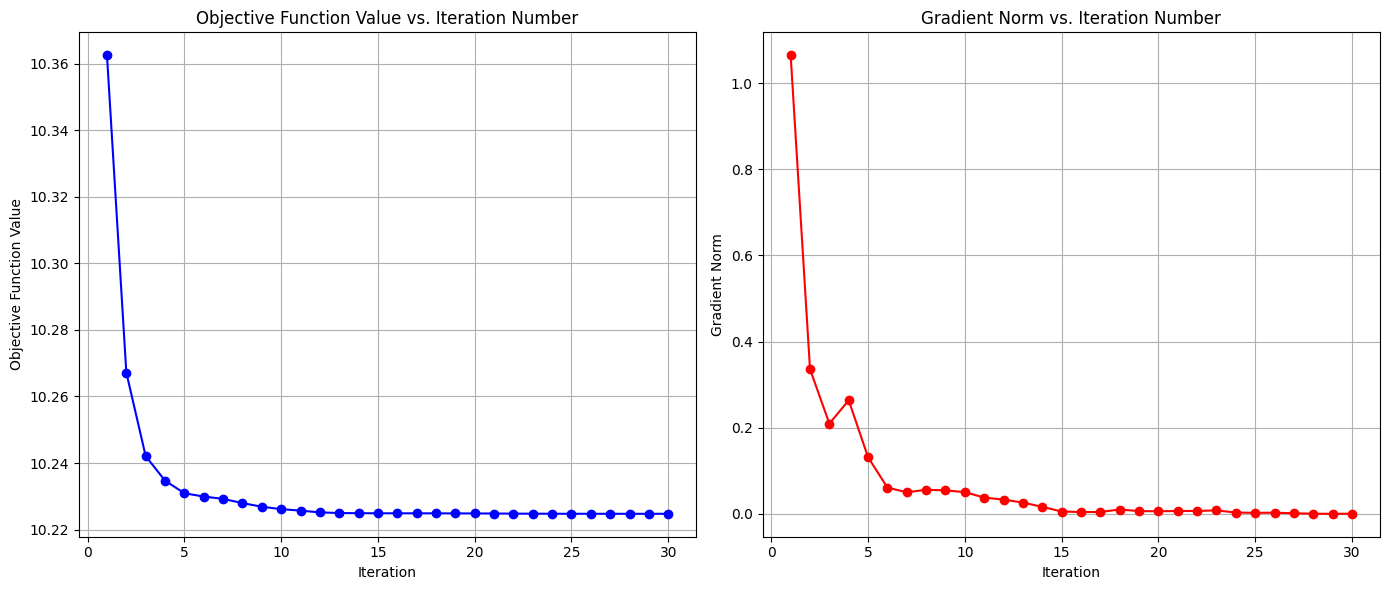

Optimization Result:
      fun: 10.224746517841073
 hess_inv: <13x13 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.10610631e-05, -3.53710193e-05, -4.68708111e-06, -5.38073879e-05,
        9.32095410e-06, -9.63620407e-06, -1.06870309e-05, -4.64796761e-05,
        2.68863132e-06,  1.01683264e-05, -2.54740406e-04, -5.86236308e-05,
       -3.50766078e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 35
      nit: 30
     njev: 35
   status: 0
  success: True
        x: array([0.40207409, 0.5559531 , 0.33427806, 0.45237212, 0.34827264,
       0.38799598, 0.61006019, 0.1218672 , 0.48658762, 0.8241449 ,
       0.50279821, 1.        , 0.5732732 ])
Optimal Parameters (best_params_descent):
[0.9020740878255031, 1.033571858157046, 7.339946385817042, 1.061897698932783, 0.06089635851593648, 3.2759919649886537, 0.9220120372970559, 0.18280079834320542, 0.07298814304042284, 0.6120724487414559, 0.5027982068336863, 1.0, 0.573273202128158]
CPU times: user 1min 5

In [153]:
%%time
best_params, objective_function = optimize_and_plot(setup='p_test_binary')

In [56]:
def generate_latin_hypercube_samples(n_samples, param_bounds):
    
    sampler = qmc.LatinHypercube(d=len(param_bounds))
    sample = sampler.random(n=n_samples)
    l_bounds = [low for low, high in param_bounds]
    u_bounds = [high for low, high in param_bounds]
    samples = qmc.scale(sample, l_bounds, u_bounds)
    return samples

def print_table_mult(names, array_init, array_best):
    # Create a dictionary for DataFrame
    data = {'Params': ['Initial params', f'Optimal params']}
    for i, name in enumerate(names):
        data[name] = [array_init[i], array_best[i]]

    df = pd.DataFrame(data)
    df.set_index('Params', inplace=True)

    # Remove the name of the index column
    df.index.name = None

    # Apply styling to make row and column names bold
    styled_df = df.style.set_table_styles(
        [{'selector': 'th', 'props': [('font-weight', 'bold')]}]
    )

    # Display the styled DataFrame
    display(styled_df)
    
def optimize_and_plot_ensemble(setup, initial_params=None, search_range=None, N_traj=1, dist_ampl=0.0, verbose=True):
    # Log setup
    list_of_indexes = [list_of_params.index(item) for item in setup_dict[setup]['parameters']]
    current_setup_min_values = [float(list_params_min[i]) for i in list_of_indexes]
    current_setup_max_values = [float(list_params_max[i]) for i in list_of_indexes]
    
    if search_range is not None:
        search_range = search_range
    else:  
        search_range = [[current_setup_min_values[i], current_setup_max_values[i]] for i in range(len(list_of_indexes))]
   
    if initial_params is not None:
        initial_params = initial_params
    else:
        initial_params = [float(sim_to_params[setup_dict[setup]['reference']][i]) if (list_params_type[i] == 'continous')
                          else 0.5 if (list_params_type[i] == 'binary')
                          else Exception('Only continous and binary variables available')
                          for i in list_of_indexes]
        
    variable_weights = setup_dict[setup]['weights']
    
    print('SETUP: ', setup)
    print('REFERENCE SIMULATION: ', setup_dict[setup]['reference'])
    print('LIST OF PARAMETERS: ', setup_dict[setup]['parameters'])
    print('INITIAL PARAMETERS: ', initial_params)
    print('SEARCH RANGE: ', search_range)
    print('LIST OF VARIABLES: ', list_of_vars)
    print('VARIABLE WEIGHTS: ', variable_weights)
    print('ENSEMBLE SIZE: ', N_traj)
    print(f'DISTURBANCE AMPLITUDE: {dist_ampl*100} %')
    
    # Generate disturbed initial conditions using Latin Hypercube Sampling
    disturbance_bounds = [
        (initial_params[i] - dist_ampl * (search_range[i][1] - search_range[i][0]), 
         initial_params[i] + dist_ampl * (search_range[i][1] - search_range[i][0]))
        for i in range(len(initial_params))
    ]

    if (dist_ampl == 0.0):
        array = np.array(initial_params)
        initial_samples = np.repeat(array[np.newaxis, ...], N_traj, axis=0)
    else:
        initial_samples = generate_latin_hypercube_samples(N_traj, disturbance_bounds)
    
    all_iteration_data = []
    all_function_values = []
    all_gradient_norms = []
    all_best_params = []
    all_results = []
    
    best_result_value = np.inf
    best_result_index = -1
    best_params_descent = None
    
    for i, sample in enumerate(initial_samples):
        # Normalize initial parameters and search range
        normalized_initial_params = normalize(sample, search_range)
        normalized_bounds = [(0, 1) for _ in search_range]
        
        # Define lists to store the progress
        iteration_data = []
        function_values = []
        gradient_norms = []

        # Define the objective function wrapper
        def objective_function(param_list):
            denorm_params = denormalize(param_list, search_range)
            prediction = predict_linear(setup, denorm_params)
            return compute_score(prediction, setup).sum()

        # Define the gradient function wrapper
        def gradient_function(param_list):
            denorm_params = denormalize(param_list, search_range)
            grad = compute_score_gradient(denorm_params, setup)
            range_values = [high - low for low, high in search_range]
            normalized_grad = [g * r for g, r in zip(grad, range_values)]
            return normalized_grad

        # Define the callback function
        def callback(xk):
            iteration = len(iteration_data) + 1
            iteration_data.append(iteration)
            function_value = objective_function(xk)
            gradient_value = gradient_function(xk)
            function_values.append(function_value)
            gradient_norms.append(np.linalg.norm(gradient_value))
            print(f"Iteration {iteration}: Objective Function Value = {function_value}, Gradient Norm = {np.linalg.norm(gradient_value)}")

        # Run the optimization
        result = minimize(
            fun=objective_function,
            x0=normalized_initial_params,
            jac=gradient_function,
            bounds=normalized_bounds,
            method='L-BFGS-B',
            callback=callback,
            options={'maxiter': 200, 'disp': True}
        )

        # Denormalize the optimal parameter values
        best_params = denormalize(result.x, search_range)
        
        all_iteration_data.append(iteration_data)
        all_function_values.append(function_values)
        all_gradient_norms.append(gradient_norms)
        all_best_params.append(best_params)
        all_results.append(result)
        
        if result.fun < best_result_value:
            best_result_value = result.fun
            best_result_index = i
            best_params_descent = best_params
        
    # Print the best result and initial parameters
    print_table_mult(names=setup_dict[setup]['parameters'], array_init=initial_params, array_best=best_params_descent)

    if verbose:
        # Plotting function value vs. iteration number for all trajectories
        plt.figure(figsize=(14, 6))

        for i in range(N_traj):
            plt.subplot(1, 2, 1)
            plt.plot(all_iteration_data[i], all_function_values[i], marker='o')
            plt.xlabel('Iteration')
            plt.ylabel('Objective Function Value')
            plt.title('Objective Function Value vs. Iteration Number')
            plt.grid(True)

            plt.subplot(1, 2, 2)
            plt.plot(all_iteration_data[i], all_gradient_norms[i], marker='o')
            plt.xlabel('Iteration')
            plt.ylabel('Gradient Norm')
            plt.title('Gradient Norm vs. Iteration Number')
            plt.grid(True)

        plt.tight_layout()
        plt.show()

    if best_params_descent is not None:
        initial_scores = compute_score(predict_linear(setup, initial_params), setup)
        final_scores = compute_score(predict_linear(setup, best_params_descent), setup)
        plot_pair_of_bars(
            initial_scores=initial_scores,
            optimal_scores=final_scores,
            labels=[list_of_vars[i] + '(L)' for i in range(len(list_of_vars) - 1)] + [list_of_vars[-1] + '(W)'],
            labels2=setup_dict[setup]['weights'],
            title='Initial vs Optimal scores (Best Simulation)',
            ylabel='Score'
        )
        var_biases = []
        for variable in list_of_vars:
        
            observations_array=np.mean(np.load(observations_files[variable]), axis=0)
            predictions_array=np.mean(predict_linear(setup, best_params_descent)[variable], axis=0)
            nan_mask_pred = np.isnan(predictions_array)
            nan_mask_obs = np.isnan(observations_array)

            nan_mask = nan_mask_obs
    
            if np.all(nan_mask):
                raise Exception(f'The model and observations datasets don\'t have the common gridpoints! Can not compute the spatial RMSE! Abort!')
            
            # Calculate the squared differences, ignoring NaN positions
            squared_differences = (predictions_array - observations_array) ** 2
    
            # Apply mask: set differences to 0 where ref is NaN
            squared_differences[nan_mask] = 0
    
            # Sum over spatial dimensions
            sum_squared_differences = np.sum(squared_differences, axis=(0, 1))

            num_spatial_points = np.sum(~nan_mask, axis=(0, 1))  # ~nan_mask gives the inverse of nan_mask
    
            # Normalize by the number of non-NaN spatial points
            normalized_sums = sum_squared_differences / num_spatial_points
    
            # Compute the square root of normalized sums to get the L2 norm
            rmses = np.sqrt(normalized_sums)

            # compute the average of rmses over all periods
            var_biases.append(rmses)
        
        print('Variables: ', list_of_vars)
        print('Variable errors:', var_biases)

    # Return the optimization results
    return best_params_descent, final_scores

SETUP:  p351
REFERENCE SIMULATION:  C2I288c
LIST OF PARAMETERS:  ['rs', 'rl', 'rlh', 'rsmf', 'tbl', 'tbla', 'ao', 'aot4', 'taw1', 'ac2']
INITIAL PARAMETERS:  [0.8, 1.0, 6.25, 1.0, 0.05, 3.25, 0.9, 0.0, 0.0, 0.0]
SEARCH RANGE:  [[0.5, 1.5], [0.7, 1.3], [5.0, 12.0], [0.7, 1.5], [0.04, 0.1], [2.5, 4.5], [0.8, 1.0], [0.0, 1.5], [0.0, 0.15], [-0.15, 0.0]]
LIST OF VARIABLES:  ['tas', 'rsds', 'tasmin', 'tasmax', 'psl', 'pr_amount', 'hfls']
VARIABLE WEIGHTS:  [0.15, 0.1, 0.15, 0.15, 0.15, 0.2, 0.1]
ENSEMBLE SIZE:  1
DISTURBANCE AMPLITUDE: 0.0 %
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         3 variables are exactly at the bounds

At iterate    0    f=  1.14541D+01    |proj g|=  7.00000D-01

At iterate    1    f=  1.10938D+01    |proj g|=  4.27717D-01
Iteration 1: Objective Function Value = 11.093846998969697, Gradient Norm = 0.6550309670864957

At iterate    2    f=  1.10129D+01    |proj g|=  3.07383D-01
Iteration

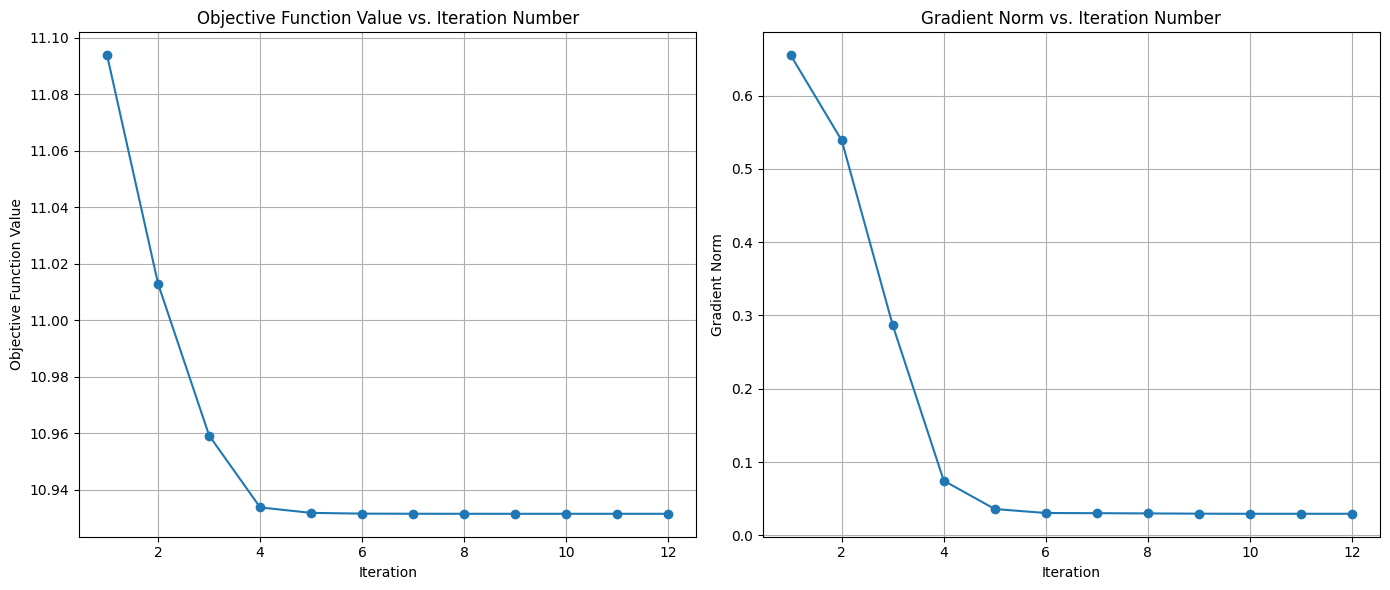

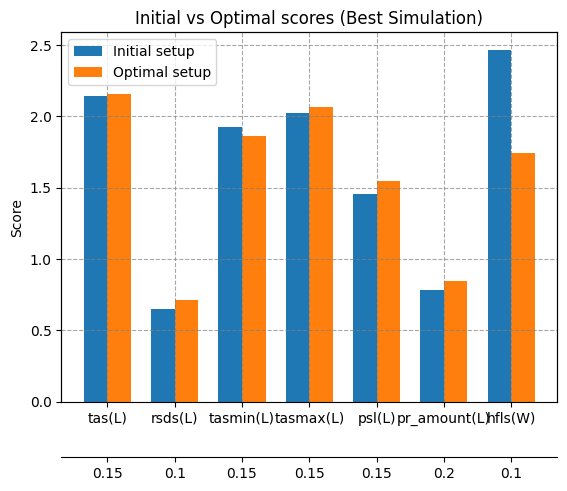

Variables:  ['tas', 'rsds', 'tasmin', 'tasmax', 'psl', 'pr_amount', 'hfls']
Variable errors: [0.9520988398297245, 8.491807031160757, 1.2077997392616542, 1.295665746698459, 101.52937735738799, 15.327462221822284, 20.36651870240482]
CPU times: user 36 s, sys: 28.6 s, total: 1min 4s
Wall time: 1min 29s


In [57]:
%%time
best_params, objective_function = optimize_and_plot_ensemble(setup='p351',N_traj=1, dist_ampl=0.0)

SETUP:  p352
REFERENCE SIMULATION:  C2I288c
LIST OF PARAMETERS:  ['rs', 'rl', 'rlh', 'rsmf', 'tbl', 'tbla', 'ao', 'aot4', 'taw1', 'ac2']
INITIAL PARAMETERS:  [0.8, 1.0, 6.25, 1.0, 0.05, 3.25, 0.9, 0.0, 0.0, 0.0]
SEARCH RANGE:  [[0.5, 1.5], [0.7, 1.3], [5.0, 12.0], [0.7, 1.5], [0.04, 0.1], [2.5, 4.5], [0.8, 1.0], [0.0, 1.5], [0.0, 0.15], [-0.15, 0.0]]
LIST OF VARIABLES:  ['tas', 'rsds', 'tasmin', 'tasmax', 'psl', 'pr_amount', 'hfls']
VARIABLE WEIGHTS:  [0.15, 0.15, 0.15, 0.15, 0.15, 0.2, 0.05]
ENSEMBLE SIZE:  1
DISTURBANCE AMPLITUDE: 0.0 %
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         3 variables are exactly at the bounds

At iterate    0    f=  1.05457D+01    |proj g|=  6.47761D-01

At iterate    1    f=  1.04455D+01    |proj g|=  4.22981D-01
Iteration 1: Objective Function Value = 10.445495948632281, Gradient Norm = 0.7648412448444251

At iterate    2    f=  1.03777D+01    |proj g|=  2.74498D-01
Iterati

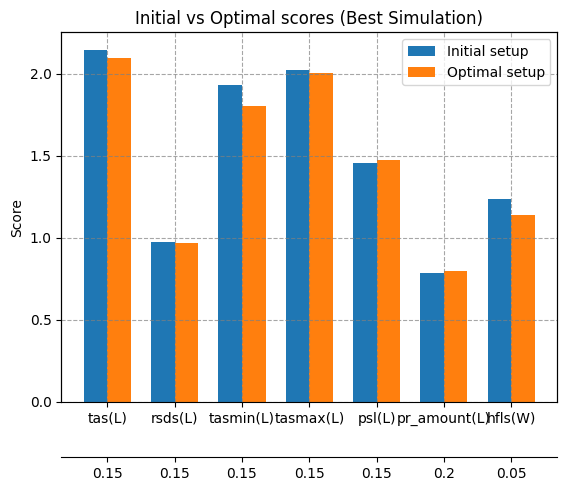

Variables:  ['tas', 'rsds', 'tasmin', 'tasmax', 'psl', 'pr_amount', 'hfls']
Variable errors: [0.9260810771920971, 7.654847048731089, 1.1839005694215006, 1.2623368351357698, 95.78018199906356, 15.63056601386631, 27.13371683841977]
CPU times: user 36 s, sys: 28.7 s, total: 1min 4s
Wall time: 1min 29s


In [58]:
%%time
best_params, objective_function = optimize_and_plot_ensemble(setup='p352',N_traj=1, dist_ampl=0.0)

SETUP:  p451
REFERENCE SIMULATION:  C2I290c
LIST OF PARAMETERS:  ['rs', 'rl', 'rlh', 'rsmf', 'tbl', 'tbla', 'ao', 'aot4', 'taw1', 'taw2']
INITIAL PARAMETERS:  [0.8, 1.0, 6.25, 1.3, 0.05, 3.25, 0.9, 1.0, 0.0, -0.05]
SEARCH RANGE:  [[0.5, 1.5], [0.7, 1.3], [5.0, 12.0], [0.7, 1.5], [0.04, 0.1], [2.5, 4.5], [0.8, 1.0], [0.0, 1.5], [0.0, 0.15], [-0.15, 0.0]]
LIST OF VARIABLES:  ['tas', 'rsds', 'tasmin', 'tasmax', 'psl', 'pr_amount', 'hfls']
VARIABLE WEIGHTS:  [0.15, 0.15, 0.15, 0.15, 0.15, 0.2, 0.05]
ENSEMBLE SIZE:  1
DISTURBANCE AMPLITUDE: 0.0 %
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  1.04955D+01    |proj g|=  5.96684D-01

At iterate    1    f=  1.04079D+01    |proj g|=  3.15280D-01
Iteration 1: Objective Function Value = 10.407881842296522, Gradient Norm = 0.6049939290420234

At iterate    2    f=  1.03715D+01    |proj g|=  2.05761D-01
Iter

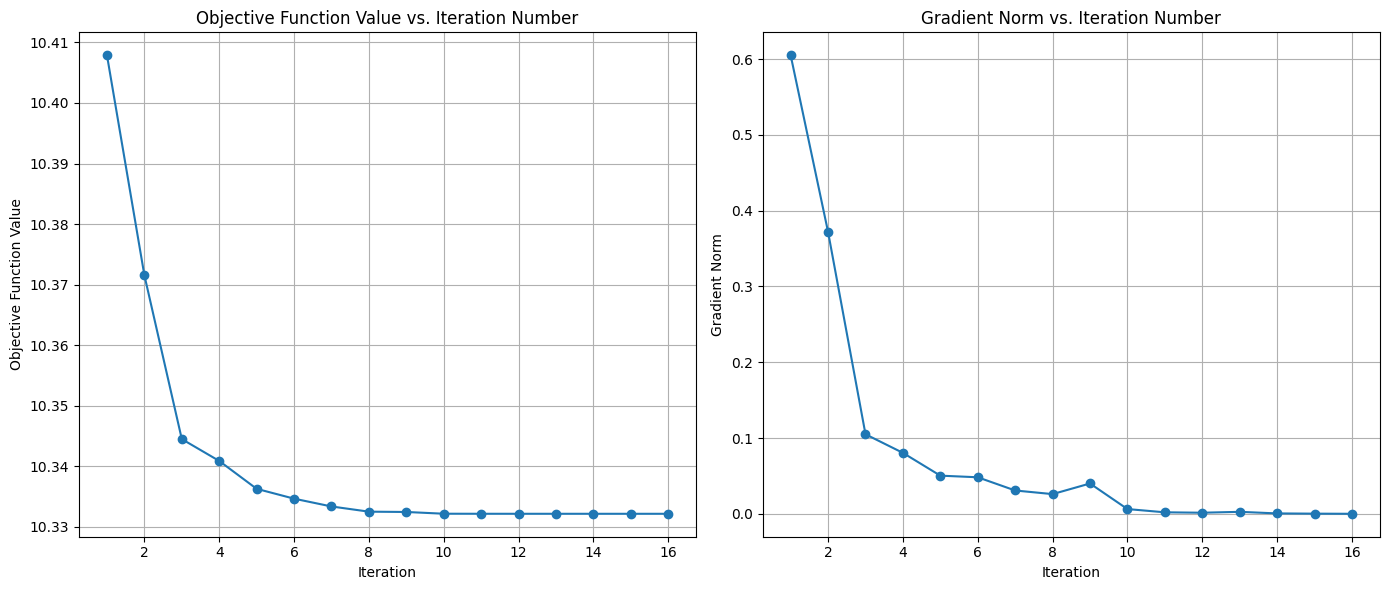

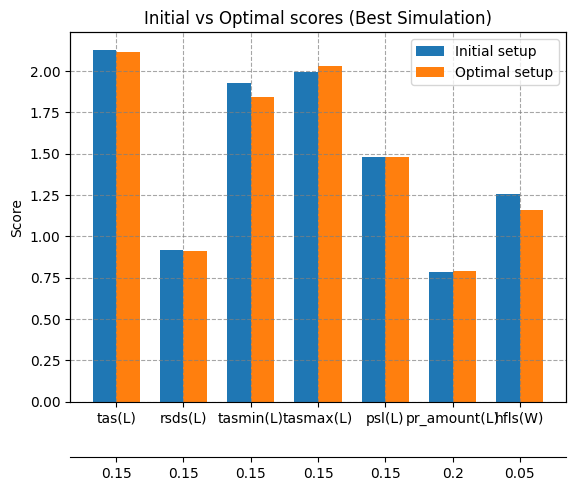

Variables:  ['tas', 'rsds', 'tasmin', 'tasmax', 'psl', 'pr_amount', 'hfls']
Variable errors: [0.9272499659911452, 7.198876231591567, 1.2074242746615105, 1.2619526230140339, 93.49624550347137, 15.277671849895988, 27.720297563413887]
CPU times: user 47.6 s, sys: 37.7 s, total: 1min 25s
Wall time: 1min 56s


In [59]:
%%time
best_params, objective_function = optimize_and_plot_ensemble(setup='p451',N_traj=1, dist_ampl=0.0)

SETUP:  p452
REFERENCE SIMULATION:  C2I290c
LIST OF PARAMETERS:  ['rs', 'rl', 'rlh', 'rsmf', 'tbl', 'tbla', 'ao', 'aot4', 'taw1', 'taw2']
INITIAL PARAMETERS:  [0.8, 1.0, 6.25, 1.3, 0.05, 3.25, 0.9, 1.0, 0.0, -0.05]
SEARCH RANGE:  [[0.5, 1.5], [0.7, 1.3], [5.0, 12.0], [0.7, 1.5], [0.04, 0.1], [2.5, 4.5], [0.8, 1.0], [0.0, 1.5], [0.0, 0.15], [-0.15, 0.0]]
LIST OF VARIABLES:  ['tas', 'rsds', 'tasmin', 'tasmax', 'psl', 'pr_amount', 'hfls']
VARIABLE WEIGHTS:  [0.15, 0.1, 0.15, 0.15, 0.15, 0.2, 0.1]
ENSEMBLE SIZE:  1
DISTURBANCE AMPLITUDE: 0.0 %
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  1.14477D+01    |proj g|=  7.00000D-01

At iterate    1    f=  1.11403D+01    |proj g|=  4.63785D-01
Iteration 1: Objective Function Value = 11.140304105900102, Gradient Norm = 0.7631110927041028

At iterate    2    f=  1.10992D+01    |proj g|=  3.67865D-01
Iterat

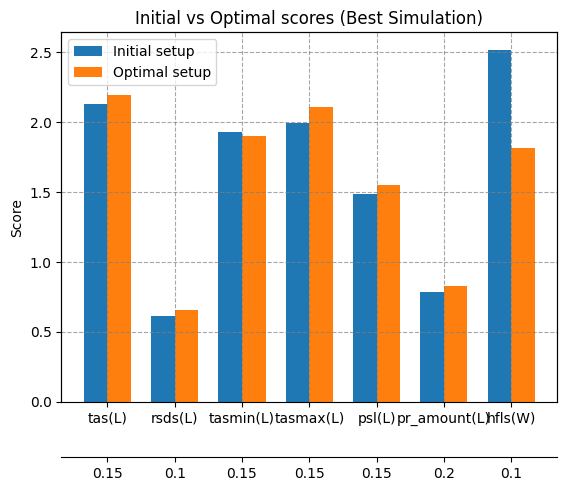

Variables:  ['tas', 'rsds', 'tasmin', 'tasmax', 'psl', 'pr_amount', 'hfls']
Variable errors: [0.9563784488770044, 7.81279582448729, 1.2349293187943882, 1.3053376400051473, 98.7900540207113, 14.794849512777311, 21.277197349260465]
CPU times: user 52.9 s, sys: 41.5 s, total: 1min 34s
Wall time: 2min 8s


In [60]:
%%time
best_params, objective_function = optimize_and_plot_ensemble(setup='p452',N_traj=1, dist_ampl=0.0)

SETUP:  p_test_binary
REFERENCE SIMULATION:  C2I288c
LIST OF PARAMETERS:  ['rs', 'rl', 'rlh', 'rsmf', 'tbl', 'tbla', 'ao', 'aot4', 'ac', 'tkhmin', 'sdb', 'acrf', 'oro']
INITIAL PARAMETERS:  [0.8, 1.0, 6.25, 1.0, 0.05, 3.25, 0.9, 0.0, 0.0, 0.6, 0.5, 0.5, 0.5]
SEARCH RANGE:  [[0.5, 1.5], [0.7, 1.3], [5.0, 12.0], [0.7, 1.5], [0.04, 0.1], [2.5, 4.5], [0.8, 1.0], [0.0, 1.5], [0.0, 0.15], [0.2, 0.7], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0]]
LIST OF VARIABLES:  ['tas', 'rsds', 'tasmin', 'tasmax', 'psl', 'pr_amount', 'hfls']
VARIABLE WEIGHTS:  [0.15, 0.15, 0.15, 0.15, 0.15, 0.2, 0.05]
ENSEMBLE SIZE:  10
DISTURBANCE AMPLITUDE: 20.0 %
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06979D+01    |proj g|=  5.52886D-01

At iterate    1    f=  1.05694D+01    |proj g|=  4.74035D-01
Iteration 1: Objective Function Value = 10.569409234721993, Gradient Norm = 1.090

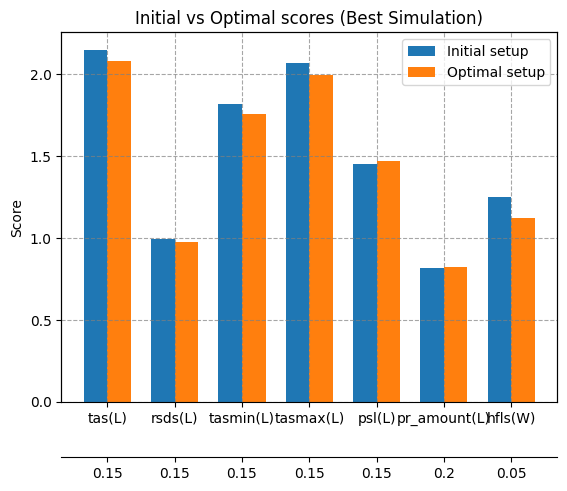

CPU times: user 15min 26s, sys: 10min 14s, total: 25min 40s
Wall time: 27min 17s


In [155]:
%%time
best_params, objective_function = optimize_and_plot_ensemble(setup='p_test_binary',N_traj=10, dist_ampl=0.2)

SETUP:  p251
REFERENCE SIMULATION:  C2I271c
LIST OF PARAMETERS:  ['rs', 'rl', 'rlh', 'rsmf', 'tbl', 'tbla', 'ao', 'aot4', 'taw1', 'ac2']
INITIAL PARAMETERS:  [0.8, 1.0, 6.25, 1.0, 0.05, 3.25, 0.9, 0.0, 0.0, 0.0]
SEARCH RANGE:  [[0.5, 1.5], [0.7, 1.3], [5.0, 12.0], [0.7, 1.5], [0.04, 0.1], [2.5, 4.5], [0.8, 1.0], [0.0, 1.5], [0.0, 0.15], [-0.15, 0.0]]
LIST OF VARIABLES:  ['tas', 'rsds', 'tasmin', 'tasmax', 'psl', 'pr_amount', 'hfls']
VARIABLE WEIGHTS:  [0.15, 0.15, 0.15, 0.15, 0.15, 0.2, 0.05]
ENSEMBLE SIZE:  5
DISTURBANCE AMPLITUDE: 20.0 %
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  1.05160D+01    |proj g|=  5.55216D-01

At iterate    1    f=  1.03409D+01    |proj g|=  4.59584D-01
Iteration 1: Objective Function Value = 10.340875348219633, Gradient Norm = 0.7458573280791583

At iterate    2    f=  1.02803D+01    |proj g|=  3.15990D-01
Iterat

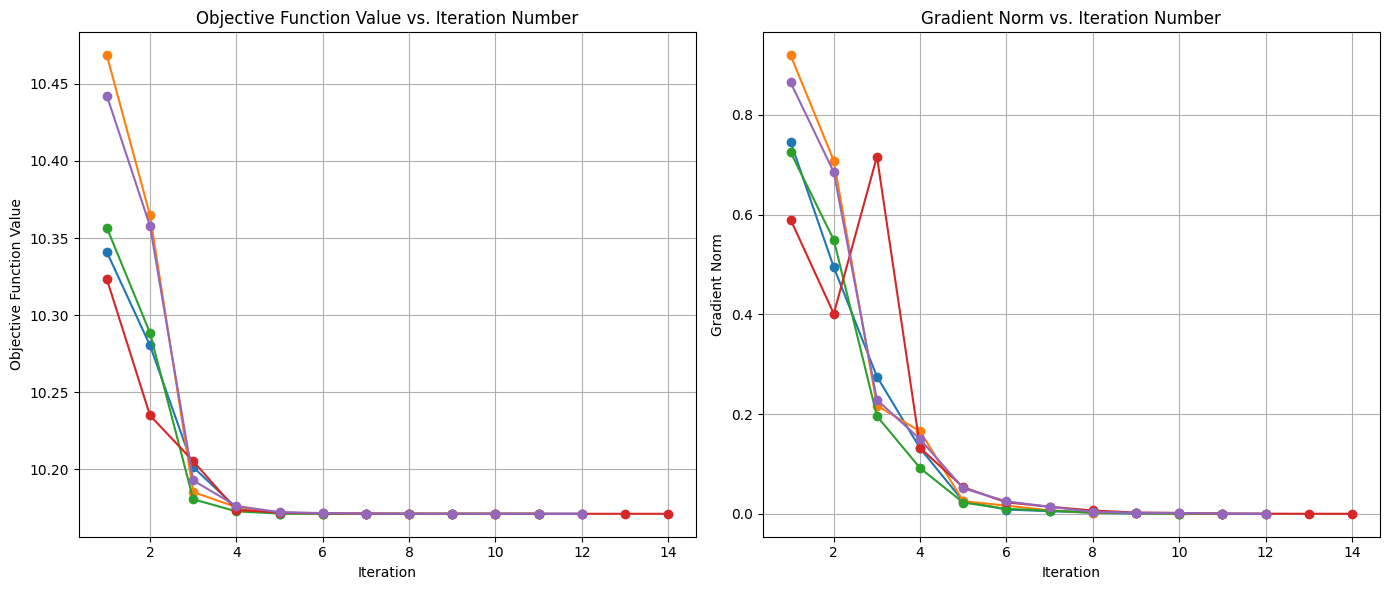

CPU times: user 3min 27s, sys: 2min 47s, total: 6min 15s
Wall time: 6min 50s


In [58]:
%%time
best_params, objective_function = optimize_and_plot_ensemble(setup='p251', N_traj=5, dist_ampl=0.2)

SETUP:  p251
REFERENCE SIMULATION:  C2I271c
LIST OF PARAMETERS:  ['rs', 'rl', 'rlh', 'rsmf', 'tbl', 'tbla', 'ao', 'aot4', 'taw1', 'ac2']
INITIAL PARAMETERS:  [0.8, 1.0, 6.25, 1.0, 0.05, 3.25, 0.9, 0.0, 0.0, 0.0]
SEARCH RANGE:  [[0.5, 1.5], [0.7, 1.3], [5.0, 12.0], [0.7, 1.5], [0.04, 0.1], [2.5, 4.5], [0.8, 1.0], [0.0, 1.5], [0.0, 0.15], [-0.15, 0.0]]
LIST OF VARIABLES:  ['tas', 'rsds', 'tasmin', 'tasmax', 'psl', 'pr_amount', 'hfls']
VARIABLE WEIGHTS: [0.15, 0.15, 0.15, 0.15, 0.15, 0.2, 0.05]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         3 variables are exactly at the bounds

At iterate    0    f=  1.05087D+01    |proj g|=  3.62803D-01

At iterate    1    f=  1.03882D+01    |proj g|=  2.58564D-01
Iteration 1: Objective Function Value = 10.388177320667872, Gradient Norm = 7.395668519410032

At iterate    2    f=  1.03167D+01    |proj g|=  3.52560D-01
Iteration 2: Objective Function Value = 10.3166711787787

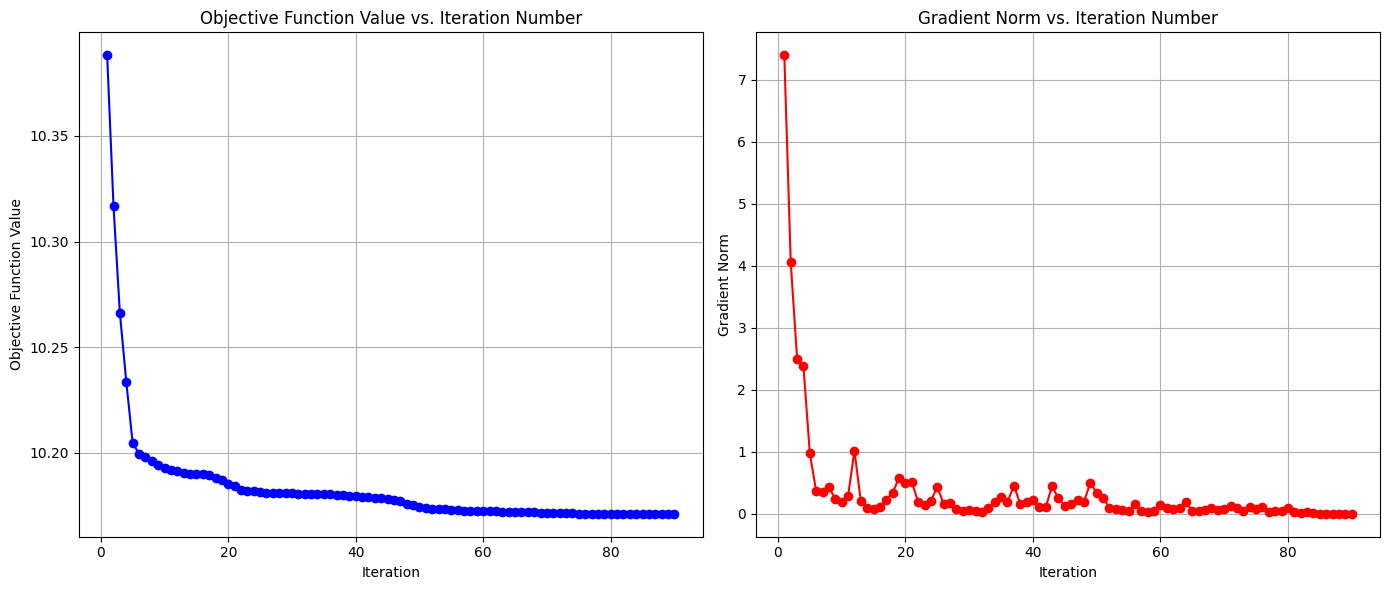

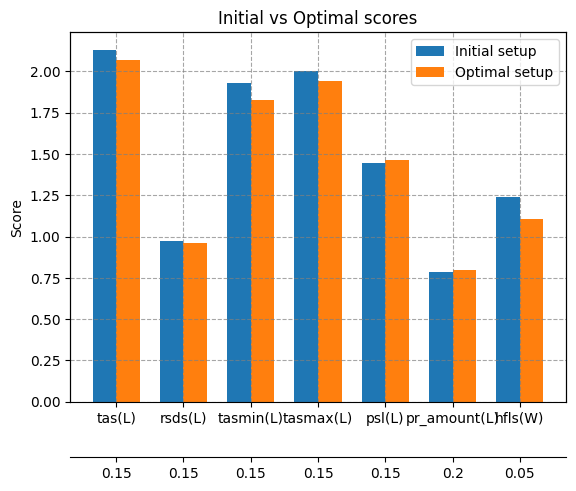

Optimization Result:
      fun: 10.17112339688655
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3.65624508e-04,  2.66307091e-04, -8.34368151e-07,  1.86249679e-04,
        5.84968733e-04,  1.51329791e-04,  1.65390954e-04, -2.18591544e-05,
        2.83106975e-04,  2.76137407e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 104
      nit: 90
     njev: 104
   status: 0
  success: True
        x: array([ 0.92690379,  1.02667938,  7.41368639,  1.07114142,  0.05859811,
        3.28507135,  0.91922273,  0.32356776,  0.08322327, -0.09494921])
Optimal Parameters (best_params_descent):
[ 0.92690379  1.02667938  7.41368639  1.07114142  0.05859811  3.28507135
  0.91922273  0.32356776  0.08322327 -0.09494921]
CPU times: user 5min 8s, sys: 3min 49s, total: 8min 57s
Wall time: 9min 21s


In [165]:
%%time
best_params, objective_function = optimize_and_plot(setup='p251')

SETUP:  p252
REFERENCE SIMULATION:  C2I271c
LIST OF PARAMETERS:  ['rs', 'rl', 'rlh', 'rsmf', 'tbl', 'tbla', 'ao', 'aot4', 'taw1', 'ac2']
INITIAL PARAMETERS:  [0.8, 1.0, 6.25, 1.0, 0.05, 3.25, 0.9, 0.0, 0.0, 0.0]
SEARCH RANGE:  [[0.5, 1.5], [0.7, 1.3], [5.0, 12.0], [0.7, 1.5], [0.04, 0.1], [2.5, 4.5], [0.8, 1.0], [0.0, 1.5], [0.0, 0.15], [-0.15, 0.0]]
LIST OF VARIABLES:  ['tas', 'rsds', 'tasmin', 'tasmax', 'psl', 'pr_amount', 'hfls']
VARIABLE WEIGHTS: [0.15, 0.1, 0.15, 0.15, 0.15, 0.2, 0.1]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         3 variables are exactly at the bounds

At iterate    0    f=  1.14238D+01    |proj g|=  7.00000D-01

At iterate    1    f=  1.10808D+01    |proj g|=  3.71330D-01
Iteration 1: Objective Function Value = 11.080836025102677, Gradient Norm = 10.182023979758803

At iterate    2    f=  1.09942D+01    |proj g|=  3.91408D-01
Iteration 2: Objective Function Value = 10.99422035758767

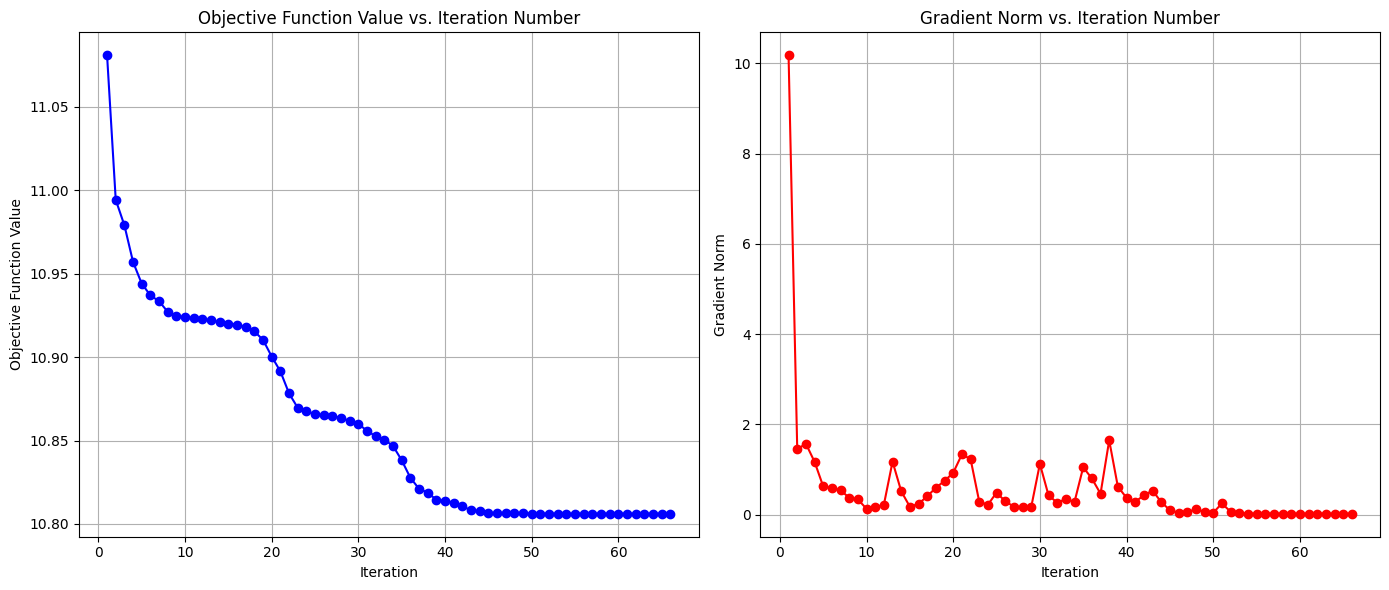

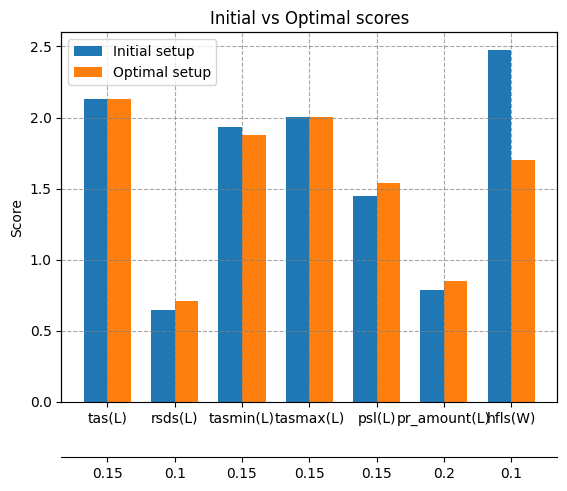

Optimization Result:
      fun: 10.80610316817941
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.24633611e-05, -2.26540386e-04, -8.10687022e-06,  1.89754539e-04,
        2.12433629e-04, -3.72386221e-05,  1.80733449e-04,  1.88824555e-02,
        6.83739671e-04, -4.51599866e-04])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 74
      nit: 66
     njev: 74
   status: 0
  success: True
        x: array([ 1.09481702,  1.01774622,  9.93563371,  1.04219738,  0.06263738,
        3.2407439 ,  0.94165094,  0.        ,  0.08594642, -0.11667577])
Optimal Parameters (best_params_descent):
[ 1.09481702  1.01774622  9.93563371  1.04219738  0.06263738  3.2407439
  0.94165094  0.          0.08594642 -0.11667577]
CPU times: user 3min 42s, sys: 2min 46s, total: 6min 29s
Wall time: 6min 44s


In [166]:
%%time
best_params, objective_function = optimize_and_plot(setup='p252')

SETUP:  p351
REFERENCE SIMULATION:  C2I288c
LIST OF PARAMETERS:  ['rs', 'rl', 'rlh', 'rsmf', 'tbl', 'tbla', 'ao', 'aot4', 'taw1', 'ac2']
INITIAL PARAMETERS:  [0.8, 1.0, 6.25, 1.0, 0.05, 3.25, 0.9, 0.0, 0.0, 0.0]
SEARCH RANGE:  [[0.5, 1.5], [0.7, 1.3], [5.0, 12.0], [0.7, 1.5], [0.04, 0.1], [2.5, 4.5], [0.8, 1.0], [0.0, 1.5], [0.0, 0.15], [-0.15, 0.0]]
LIST OF VARIABLES:  ['tas', 'rsds', 'tasmin', 'tasmax', 'psl', 'pr_amount', 'hfls']
VARIABLE WEIGHTS:  [0.15, 0.1, 0.15, 0.15, 0.15, 0.2, 0.1]
ENSEMBLE SIZE:  5
DISTURBANCE AMPLITUDE: 20.0 %
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  1.13480D+01    |proj g|=  6.53774D-01

At iterate    1    f=  1.10708D+01    |proj g|=  3.49462D-01
Iteration 1: Objective Function Value = 11.070796877365849, Gradient Norm = 0.6299384421246688

At iterate    2    f=  1.10097D+01    |proj g|=  2.93757D-01
Iteratio

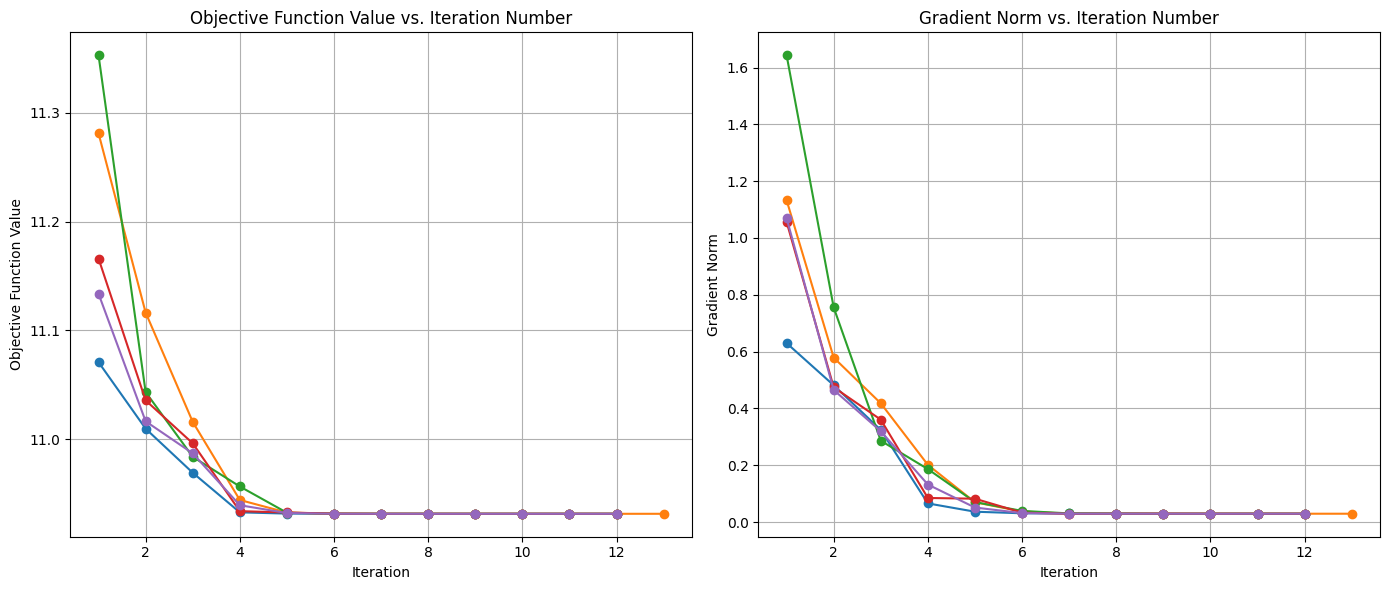

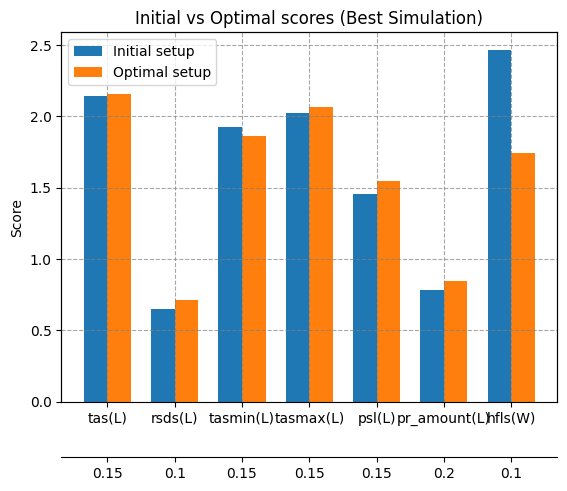

Variables:  ['tas', 'rsds', 'tasmin', 'tasmax', 'psl', 'pr_amount', 'hfls']
Variable errors: [14.3680571   7.13851151 12.39343828 13.75599689 10.33170004  4.23083048
 17.44077516]
CPU times: user 2min 54s, sys: 2min 18s, total: 5min 12s
Wall time: 5min 25s


In [30]:
%%time
best_params, objective_function = optimize_and_plot_ensemble(setup='p351', N_traj=5, dist_ampl=0.2)

SETUP:  p352
REFERENCE SIMULATION:  C2I288c
LIST OF PARAMETERS:  ['rs', 'rl', 'rlh', 'rsmf', 'tbl', 'tbla', 'ao', 'aot4', 'taw1', 'ac2']
INITIAL PARAMETERS:  [0.8, 1.0, 6.25, 1.0, 0.05, 3.25, 0.9, 0.0, 0.0, 0.0]
SEARCH RANGE:  [[0.5, 1.5], [0.7, 1.3], [5.0, 12.0], [0.7, 1.5], [0.04, 0.1], [2.5, 4.5], [0.8, 1.0], [0.0, 1.5], [0.0, 0.15], [-0.15, 0.0]]
LIST OF VARIABLES:  ['tas', 'rsds', 'tasmin', 'tasmax', 'psl', 'pr_amount', 'hfls']
VARIABLE WEIGHTS:  [0.15, 0.15, 0.15, 0.15, 0.15, 0.2, 0.05]
ENSEMBLE SIZE:  1
DISTURBANCE AMPLITUDE: 0.0 %
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         3 variables are exactly at the bounds

At iterate    0    f=  1.05457D+01    |proj g|=  6.47761D-01

At iterate    1    f=  1.04455D+01    |proj g|=  4.22981D-01
Iteration 1: Objective Function Value = 10.445495948640499, Gradient Norm = 0.764841246187391

At iterate    2    f=  1.03777D+01    |proj g|=  2.74498D-01
Iteratio

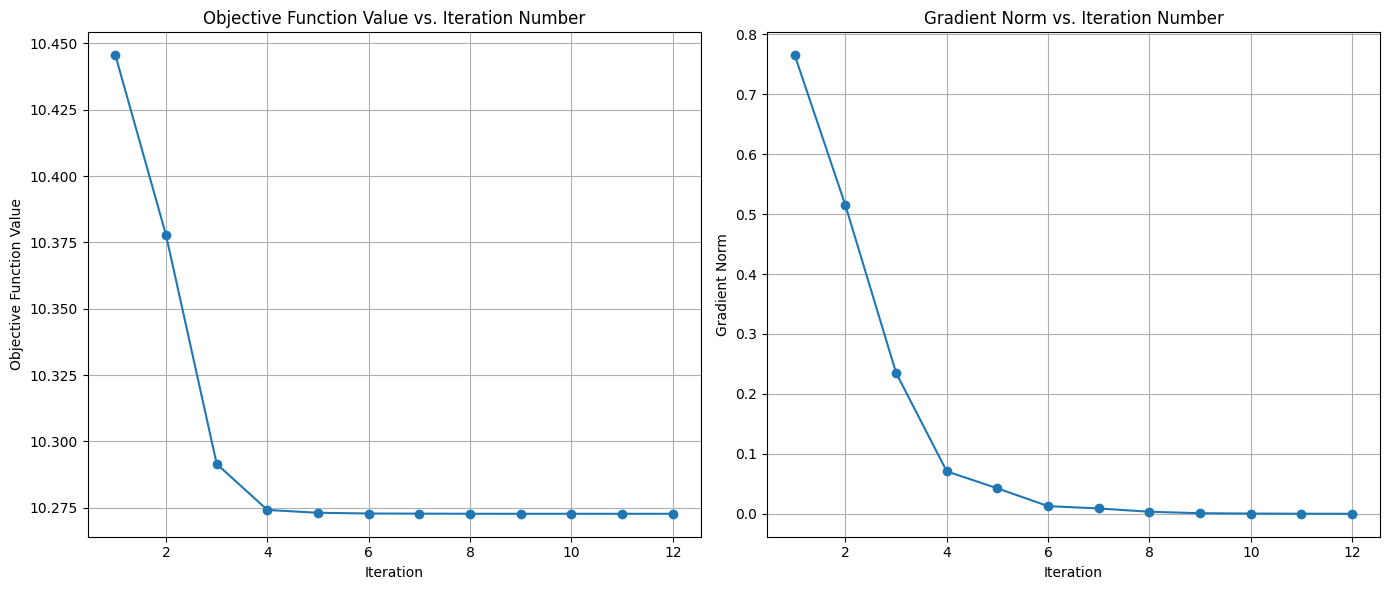

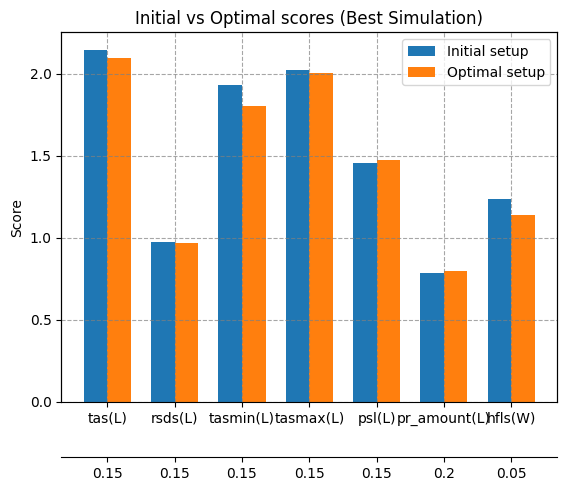

CPU times: user 41.7 s, sys: 33.3 s, total: 1min 15s
Wall time: 1min 24s


In [63]:
%%time
best_params, objective_function = optimize_and_plot_ensemble(setup='p352', N_traj=1, dist_ampl=0.0)

SETUP:  p441
REFERENCE SIMULATION:  C2I290c
LIST OF PARAMETERS:  ['rs', 'rl', 'rlh', 'rsmf', 'tbl', 'tbla', 'ao', 'ac']
INITIAL PARAMETERS:  [0.8, 1.0, 6.25, 1.3, 0.05, 3.25, 0.9, 0.0]
SEARCH RANGE:  [[0.5, 1.5], [0.7, 1.3], [5.0, 12.0], [0.7, 1.5], [0.04, 0.1], [2.5, 4.5], [0.8, 1.0], [0.0, 0.15]]
LIST OF VARIABLES:  ['tas', 'rsds', 'tasmin', 'tasmax', 'psl', 'pr_amount', 'hfls']
VARIABLE WEIGHTS: [0.15, 0.1, 0.15, 0.15, 0.15, 0.2, 0.1]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  1.14477D+01    |proj g|=  7.00000D-01

At iterate    1    f=  1.12638D+01    |proj g|=  5.44773D-01
Iteration 1: Objective Function Value = 11.263799601832105, Gradient Norm = 8.848136885577313

At iterate    2    f=  1.11623D+01    |proj g|=  3.80078D-01
Iteration 2: Objective Function Value = 11.16232519893136, Gradient Norm = 2.8037537535499157

At iterate    3 

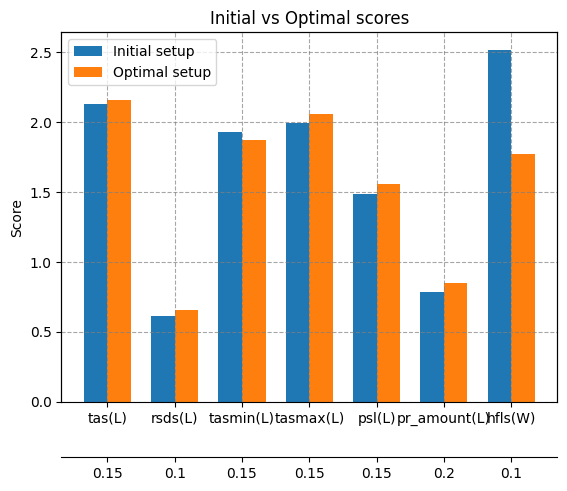

Optimization Result:
      fun: 10.919761477770562
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.05538506e-04,  1.64380812e-04,  1.06131238e-06, -3.38865342e-05,
        3.36560506e-05, -3.96295359e-05,  1.01048757e-04, -1.42574255e-04])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 62
      nit: 53
     njev: 62
   status: 0
  success: True
        x: array([1.08357195, 1.02207405, 9.94406594, 1.33668024, 0.06361381,
       3.27697088, 0.93290387, 0.08370492])
Optimal Parameters (best_params_descent):
[1.08357195 1.02207405 9.94406594 1.33668024 0.06361381 3.27697088
 0.93290387 0.08370492]
CPU times: user 2min 19s, sys: 1min 54s, total: 4min 13s
Wall time: 4min 20s


In [121]:
%%time
best_params, objective_function = optimize_and_plot(setup='p441')

SETUP:  p442
REFERENCE SIMULATION:  C2I290c
LIST OF PARAMETERS:  ['rs', 'rl', 'rlh', 'rsmf', 'tbl', 'tbla', 'ao', 'ac']
INITIAL PARAMETERS:  [0.8, 1.0, 6.25, 1.3, 0.05, 3.25, 0.9, 0.0]
SEARCH RANGE:  [[0.5, 1.5], [0.7, 1.3], [5.0, 12.0], [0.7, 1.5], [0.04, 0.1], [2.5, 4.5], [0.8, 1.0], [0.0, 0.15]]
LIST OF VARIABLES:  ['tas', 'rsds', 'tasmin', 'tasmax', 'psl', 'pr_amount', 'hfls']
VARIABLE WEIGHTS: [0.15, 0.15, 0.15, 0.15, 0.15, 0.2, 0.05]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  1.04955D+01    |proj g|=  3.74704D-01

At iterate    1    f=  1.03611D+01    |proj g|=  2.05053D-01
Iteration 1: Objective Function Value = 10.361079199338565, Gradient Norm = 5.74420901516634

At iterate    2    f=  1.03222D+01    |proj g|=  3.57575D-01
Iteration 2: Objective Function Value = 10.322230661958216, Gradient Norm = 3.3032233821917765

At iterate    

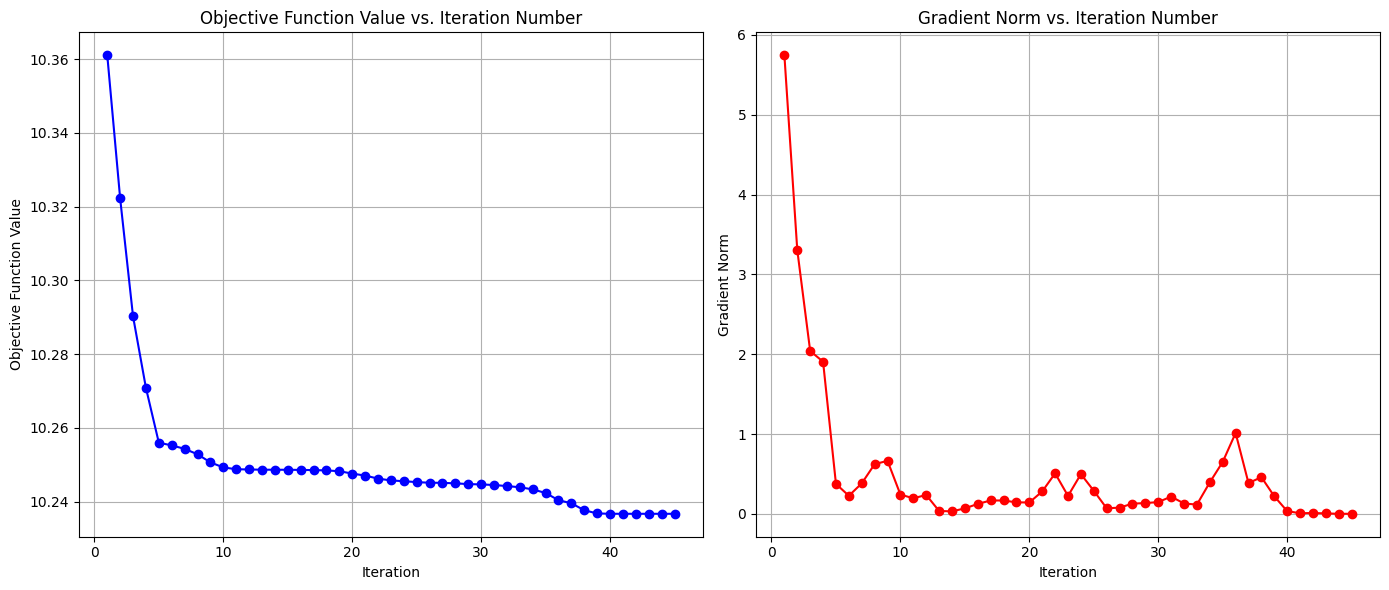

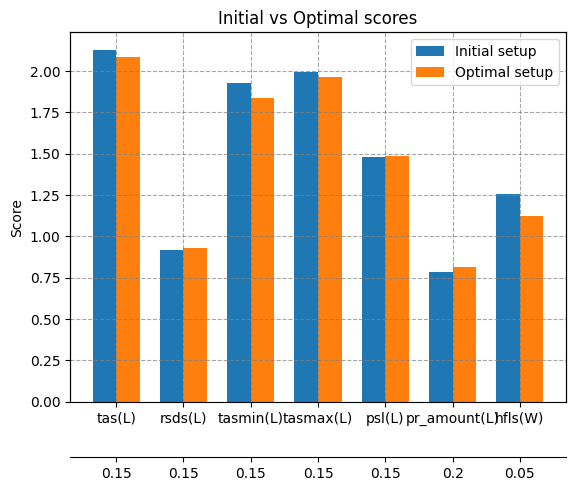

Optimization Result:
      fun: 10.236714053464322
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.65972967e-04, -3.11141223e-04, -2.67117989e-05,  2.20534114e-04,
        9.12568197e-04,  1.21281014e-04, -3.55006193e-04,  2.49041889e-04])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 50
      nit: 45
     njev: 50
   status: 0
  success: True
        x: array([0.9279902 , 1.02790838, 7.4265502 , 1.33466629, 0.05911366,
       3.31026247, 0.91357446, 0.07429741])
Optimal Parameters (best_params_descent):
[0.9279902  1.02790838 7.4265502  1.33466629 0.05911366 3.31026247
 0.91357446 0.07429741]
CPU times: user 1min 56s, sys: 1min 34s, total: 3min 30s
Wall time: 3min 36s


In [122]:
%%time
best_params, objective_function = optimize_and_plot(setup='p442')

SETUP:  p451
REFERENCE SIMULATION:  C2I290c
LIST OF PARAMETERS:  ['rs', 'rl', 'rlh', 'rsmf', 'tbl', 'tbla', 'ao', 'aot4', 'taw1', 'taw2']
INITIAL PARAMETERS:  [0.8, 1.0, 6.25, 1.3, 0.05, 3.25, 0.9, 1.0, 0.0, -0.05]
SEARCH RANGE:  [[0.5, 1.5], [0.7, 1.3], [5.0, 12.0], [0.7, 1.5], [0.04, 0.1], [2.5, 4.5], [0.8, 1.0], [0.0, 1.5], [0.0, 0.15], [-0.15, 0.0]]
LIST OF VARIABLES:  ['tas', 'rsds', 'tasmin', 'tasmax', 'psl', 'pr_amount', 'hfls']
VARIABLE WEIGHTS: [0.15, 0.15, 0.15, 0.15, 0.15, 0.2, 0.05]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  1.04955D+01    |proj g|=  5.96684D-01

At iterate    1    f=  1.04079D+01    |proj g|=  3.15280D-01
Iteration 1: Objective Function Value = 10.407881842314813, Gradient Norm = 0.6049939301079523

At iterate    2    f=  1.03715D+01    |proj g|=  2.05761D-01
Iteration 2: Objective Function Value = 10.371541425

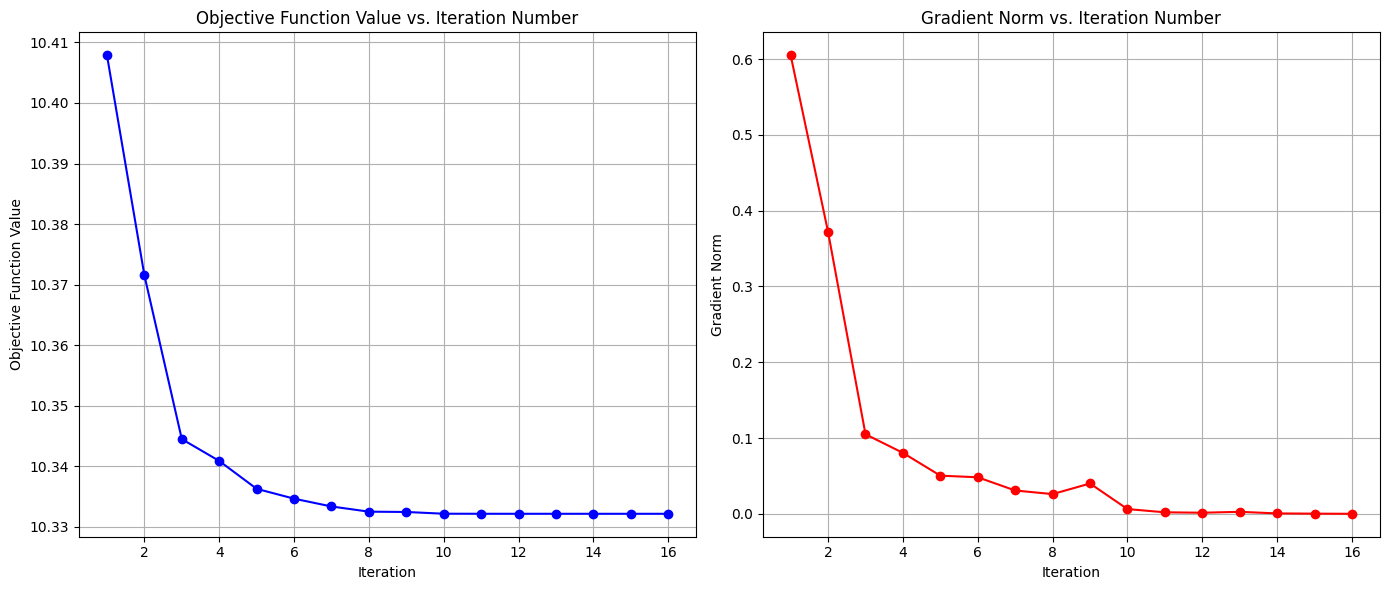

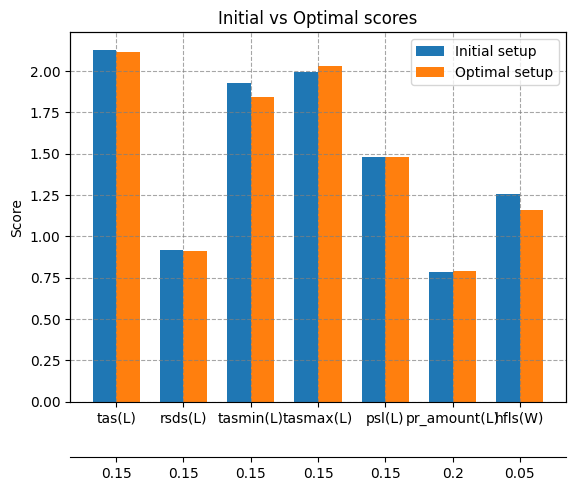

Optimization Result:
      fun: 10.332149375162928
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([-7.31958777e-06,  7.38213555e-06,  1.80904617e-05,  1.20109405e-05,
       -7.94169972e-06,  1.92951901e-05,  3.10771432e-05, -1.82234135e-06,
        4.97704708e-06, -2.40330715e-06])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 19
      nit: 16
     njev: 19
   status: 0
  success: True
        x: array([0.40163362, 0.55025144, 0.30001408, 0.82767198, 0.35083889,
       0.36691271, 0.56545137, 0.73241866, 0.34672714, 0.35467497])
Optimal Parameters (best_params_descent):
[0.9016336218463781, 1.030150862000681, 7.100098569132657, 1.3621375844092305, 0.06105033336053756, 3.2338254158755713, 0.9130902747159041, 1.0986279907659224, 0.05200907105485711, -0.0967987551853215]
CPU times: user 56 s, sys: 44.5 s, total: 1min 40s
Wall time: 1min 44s


In [38]:
%%time
best_params, objective_function = optimize_and_plot(setup='p451')

SETUP:  p452
REFERENCE SIMULATION:  C2I290c
LIST OF PARAMETERS:  ['rs', 'rl', 'rlh', 'rsmf', 'tbl', 'tbla', 'ao', 'aot4', 'taw1', 'taw2']
INITIAL PARAMETERS:  [0.8, 1.0, 6.25, 1.3, 0.05, 3.25, 0.9, 1.0, 0.0, -0.05]
SEARCH RANGE:  [[0.5, 1.5], [0.7, 1.3], [5.0, 12.0], [0.7, 1.5], [0.04, 0.1], [2.5, 4.5], [0.8, 1.0], [0.0, 1.5], [0.0, 0.15], [-0.15, 0.0]]
LIST OF VARIABLES:  ['tas', 'rsds', 'tasmin', 'tasmax', 'psl', 'pr_amount', 'hfls']
VARIABLE WEIGHTS: [0.15, 0.1, 0.15, 0.15, 0.15, 0.2, 0.1]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  1.14477D+01    |proj g|=  7.00000D-01

At iterate    1    f=  1.11403D+01    |proj g|=  4.63785D-01
Iteration 1: Objective Function Value = 11.140304105928314, Gradient Norm = 0.7631110931006239

At iterate    2    f=  1.10992D+01    |proj g|=  3.67865D-01
Iteration 2: Objective Function Value = 11.09918672041

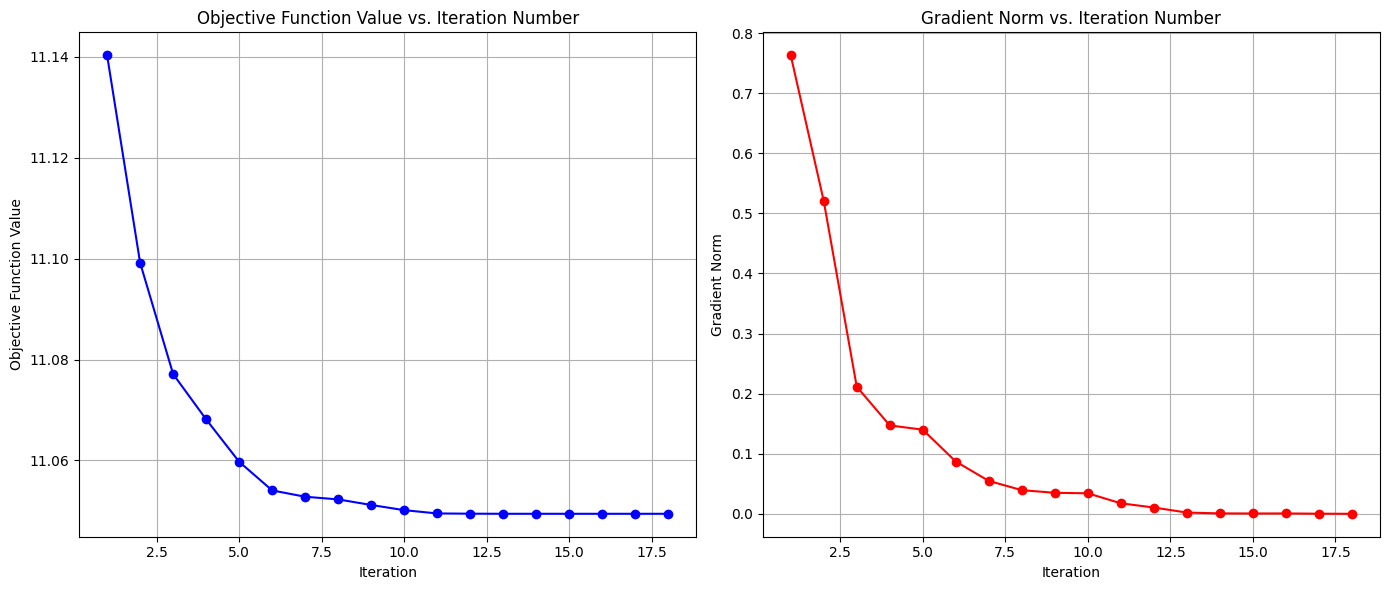

Optimization Result:
      fun: 11.049419077594047
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([-4.36875333e-06, -2.69142915e-05, -2.39244556e-05,  6.36050315e-06,
        2.26988111e-05, -2.07873074e-05,  2.77631272e-05, -3.47319993e-05,
       -1.25450338e-05, -4.10000486e-06])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 21
      nit: 18
     njev: 21
   status: 0
  success: True
        x: array([0.56299916, 0.53579211, 0.66521131, 0.80478079, 0.43742428,
       0.33601316, 0.66914591, 0.5571392 , 0.31221827, 0.32034637])
Optimal Parameters (best_params_descent):
[1.0629991584540286, 1.021475263279965, 9.656479145948255, 1.3438246317809501, 0.06624545709449256, 3.1720263195675553, 0.9338291823731001, 0.8357088016178702, 0.04683274068452349, -0.10194804418340889]
CPU times: user 1min 1s, sys: 48.9 s, total: 1min 50s
Wall time: 1min 54s


In [39]:
%%time
best_params, objective_function = optimize_and_plot(setup='p452')

In [23]:
%%time
best_params, objective_function = optimize_and_plot_ensemble(setup='p541', N_traj=5, dist_ampl=0.2)

SETUP:  p541
REFERENCE SIMULATION:  C2I200
LIST OF PARAMETERS:  ['rs', 'rl', 'rlh', 'rsmf', 'tbl', 'tbla', 'ao', 'ac']
INITIAL PARAMETERS:  [0.8, 1.0, 10.0, 1.0, 0.05, 3.25, 1.0, 0.0]
SEARCH RANGE:  [[0.5, 1.5], [0.7, 1.3], [5.0, 12.0], [0.7, 1.5], [0.04, 0.1], [2.5, 4.5], [0.8, 1.0], [0.0, 0.15]]
LIST OF VARIABLES:  ['tas', 'rsds', 'tasmin', 'tasmax', 'psl', 'pr_amount', 'hfls']
VARIABLE WEIGHTS:  [0.15, 0.1, 0.15, 0.15, 0.15, 0.2, 0.1]
ENSEMBLE SIZE:  5
DISTURBANCE AMPLITUDE: 20.0 %
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  1.49805D+01    |proj g|=  6.05368D-01

At iterate    1    f=  1.47883D+01    |proj g|=  4.09896D-01
Iteration 1: Objective Function Value = 14.788301103107925, Gradient Norm = 0.7153798768907734

At iterate    2    f=  1.46945D+01    |proj g|=  2.66214D-01
Iteration 2: Objective Function Value = 14.694462873387911, Gr

CPU times: user 2min 14s, sys: 2min 19s, total: 4min 34s
Wall time: 4min 43s


SETUP:  p641
REFERENCE SIMULATION:  C2I200c
LIST OF PARAMETERS:  ['rs', 'rl', 'rlh', 'rsmf', 'tbl', 'tbla', 'ao', 'ac']
INITIAL PARAMETERS:  [0.8, 1.0, 10.0, 1.0, 0.05, 3.25, 1.0, 0.0]
SEARCH RANGE:  [[0.5, 1.5], [0.7, 1.3], [5.0, 12.0], [0.7, 1.5], [0.04, 0.1], [2.5, 4.5], [0.8, 1.0], [0.0, 0.15]]
LIST OF VARIABLES:  ['tas', 'rsds', 'tasmin', 'tasmax', 'psl', 'pr_amount', 'hfls']
VARIABLE WEIGHTS:  [0.15, 0.1, 0.15, 0.15, 0.15, 0.2, 0.1]
ENSEMBLE SIZE:  5
DISTURBANCE AMPLITUDE: 20.0 %
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  1.13301D+01    |proj g|=  6.13750D-01

At iterate    1    f=  1.10258D+01    |proj g|=  4.06379D-01
Iteration 1: Objective Function Value = 11.025827897574576, Gradient Norm = 0.7487762268070275

At iterate    2    f=  1.09437D+01    |proj g|=  1.70059D-01
Iteration 2: Objective Function Value = 10.94372018783261, Gr

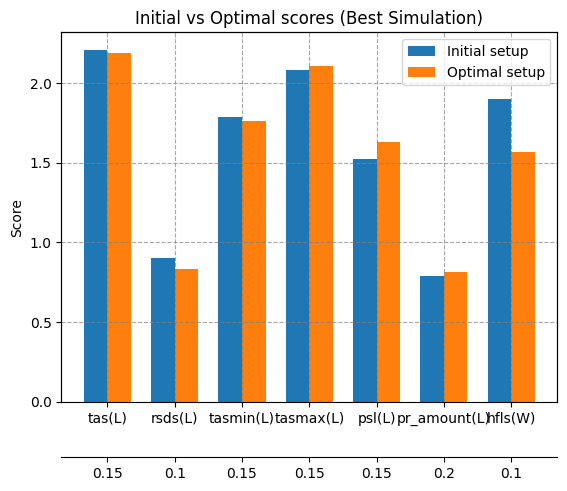

CPU times: user 2min 21s, sys: 2min 28s, total: 4min 50s
Wall time: 4min 59s


In [24]:
%%time
best_params, objective_function = optimize_and_plot_ensemble(setup='p641', N_traj=5, dist_ampl=0.2)

# ANALYSIS

# MONTE CARLO WITH LATIN HYPERCUBE

In [ ]:
# Number of samples
n_samples = 10000

# Initialize Latin Hypercube Sampler
sampler = qmc.LatinHypercube(d=5)
sample = sampler.random(n=n_samples)

# Scale samples to the parameter ranges
scaled_sample = qmc.scale(sample, search_range[:, 0], search_range[:, 1])

function_values = []
for x in tqdm(scaled_sample, desc="Evaluating function"):
    function_values.append(f(x))
function_values = np.array(function_values)

In [ ]:
# Find the minimum function value and corresponding parameters
min_index = np.argmin(function_values)
best_params = scaled_sample[min_index]
min_score = function_values[min_index]

print("Best parameters:", best_params)
print("Minimum score:", min_score)

In [ ]:
best_params

In [ ]:
plot_bars(compute_score(predict_linear(best_params_descent)))

# ANALYSIS OF THE RESULT

In [ ]:
print('Best L-BFGS-B ', best_params_descent)

In [ ]:
def plot_bars(numbers,
              labels = ['tas','rsds','tasmin','tasmax','psl','pr_amount','hfsl']):
    
    numbers = np.array(numbers)
    
    total_sum = numbers.sum()
    
    # Calculate the percentages
    percentages = [(number / total_sum) * 100 for number in numbers]

    # Create labels for each bar
    labels = labels[:len(numbers)]

    # Plot the bars
    plt.figure(figsize=(10, 6))
    bars = plt.bar(labels, percentages, color='skyblue')

    # Add value labels on top of the bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}%', ha='center', va='bottom')

    # Add title and labels
    plt.title('Percentage of Each Variable Contribution to the Total Norm ( RMSEn(VAR-OBS)*COEFF )')
    plt.ylabel('Percentage (%)')
    plt.ylim(0, 100)

    # Display the plot
    plt.show()

In [ ]:
plot_bars(compute_score(predict_linear(best_params)))

0.2, 0.1, 0.1, 0.2, 0.2, 0.1, 0.1


In [ ]:
plot_bars(compute_score(predict_linear(training_params['C2I268c'])))

In [ ]:
params_increment = [0.05, 0.05, 2.0, 0.2, 0.1]
params_plot_range = [[max(best_params[i]-params_increment[i], search_range[i][0]),
                      min(best_params[i]+params_increment[i], search_range[i][1])] for i in range(5)]

In [ ]:
print(params_plot_range)

In [ ]:
# Number of parameters
num_points = 10

num_params = search_range.shape[0]

# Create a grid for subplots
fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(num_params, num_params, wspace=0.3, hspace=0.3)

# Find the min and max values for the function values for color normalization
min_value = 11.6
max_value = 12.3
norm = mcolors.Normalize(vmin=min_value, vmax=max_value)

# Generate heatmaps
contour_plots = []
for i in range(num_params):
    for j in range(num_params):
        if i < j:
            ax = fig.add_subplot(gs[i, j])
            # Create grid for heatmap
            xi = np.linspace(params_plot_range[i][0], params_plot_range[i][1], num_points)
            xj = np.linspace(params_plot_range[j][0], params_plot_range[j][1], num_points)
            Xi, Xj = np.meshgrid(xi, xj)

            Z = np.zeros_like(Xi)

            total_function_eval = num_points*num_points
            with tqdm(total=total_function_eval, desc="Evaluating f") as pbar:
                for i1 in range(num_points):
                    for j1 in range(num_points):
                        params = best_params.copy()
                        params[i] = Xi[i1, j1]
                        params[j] = Xj[i1, j1]
                        Z[i1, j1] = f(params)
                        pbar.update(1)
            
            # Plot heatmap
            c = ax.contourf(Xi, Xj, Z, levels=30, cmap='coolwarm', norm=norm, extend='both')
            contour_plots.append(c)

            # Plot optimal parameters
            ax.plot(best_params[i], best_params[j], 'D', color='lime', markersize=10)
            ax.set_xlabel(f'{list_of_params[i]}')
            ax.set_ylabel(f'{list_of_params[j]}')
        else:
            # Remove self-plots and duplicates
            fig.delaxes(fig.add_subplot(gs[i, j]))

# Add a single colorbar for all plots
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(contour_plots[0], cax=cbar_ax, norm=norm)
cbar.set_label('Score Value')

plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(function_values, bins=100, edgecolor='black', alpha=0.7)
plt.title('Histogram of norm values hor hypercube simulations')
plt.xlabel('Norm')
plt.ylabel('Frequency')
plt.grid(True)

plt.axvline(x=f(training_params['C2I268c']), color='red', linestyle='--', linewidth=1.5, label='Reference')
plt.axvline(x=min_score, color='black', linestyle='--', linewidth=1.5, label='Optimal')

plt.legend()
plt.show()